# Modeling the Joint Distribution of Wind Speed and Direction  using Gaussain Mixture Modles

OEN Method: Harris, Cook
The parent wind speed distribution: Why Weibull?
http://www.sciencedirect.com/science/article/pii/S0167610514001056

Gaussian Mixture Models, 
http://scikit-learn.org/stable/modules/mixture.html

# 1. Set up

## 1.1 Environment

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from import_file import *
load_libs()

In [2]:
## Input params used outside this notebook
# params = {'gaussian_number': 4, 'file_path': "./data/NCDC/uk/weybourne/dat.txt"}
dictget = lambda d, *k: [d[i] for i in k]
if 'params' in globals():
    input_file_path, NUMBER_OF_GAUSSIAN, FIT_METHOD, KDE_GRIDSEARCH = dictget(params, 'input_file_path', 
                                                                              'gaussian_number', 
                                                                              'fit_method', 'kde_gridsearch')

## 1.2 Read Data

In [3]:
# ipath= './data/NCDC/uk/boscombe_down/dat.txt' # 4?
# ipath= './data/NCDC/uk/middle_wallop/dat.txt' # good
# ipath= './data/NCDC/uk/southhamption/dat.txt'
# ipath= './data/NCDC/uk/bournemouth/dat.txt'
# ipath= './data/NCDC/tiree.txt' # try 4
# ipath= "./data/NCDC/uk/bealach_na_ba/dat.txt" # 
# ipath= "./data/NCDC/uk/skye_lusa/dat.txt" # 
# ipath= "./data/NCDC/uk/south_uist_range/dat.txt" 
# ipath= "./data/NCDC/marham.txt"
# ipath= "./data/NCDC/uk/holbeach/dat.txt"
# ipath= "./data/NCDC/uk/weybourne/dat.txt"
# ipath= "./data/NCDC/uk/cambridge/dat.txt"
# ipath= "./data/NCDC/uk/wattisham/dat.txt"
# ipath= "./data/NCDC/uk/benbecula/dat.txt" # truncate (untruncate in m/s), 4?

# ipath= "./data/NCDC/southeast_asia/paya_lebar/dat.txt" # high initial speed(m/s is ok), recent 5 year is different
# ipath= "./data/NCDC/southeast_asia/sultan_ismail/dat.txt" # 
# ipath= "./data/NCDC/southeast_asia/singapore_changi/dat.txt" # time shift, high 0, weird direction
# ipath= "./data/NCDC/east_asia/cheongju_intl/dat.txt" # recent 5 year may have problem
# ipath= "./data/NCDC/east_asia/daegu_ab/dat.txt" # recent 5 year may have problem

# ipath= "./data/NCDC/canada/melita_man/dat.txt" # 
# ipath= "./data/NCDC/canada/mildred_lake_alta/dat.txt" # uptail wind speed 
# ipath= "./data/NCDC/canada/manouane_est_que/dat.txt"  
# ipath= "./data/NCDC/canada/argentia/dat.txt" # weird shape

# ipath= "./data/NCDC/europe/landsberg_lech/dat.txt" # very good, can try 4
# ipath= "./data/NCDC/europe/vatry/dat.txt"  # double peak, initial speed (should be good with m/s)
# ipath= "./data/NCDC/europe/avord/dat.txt" # try 4, initial speed (should be good with m/s)
# ipath= './data/NCDC/europe/ciampino/dat.txt' # try 4, watch for KDE bandwidth
# ipath= "./data/NCDC/europe/holzdorf/dat.txt"
# ipath= "./data/NCDC/europe/neuburg/dat.txt"
# ipath= "./data/NCDC/europe/valladolid/dat.txt"
# ipath= "./data/NCDC/europe/laupheim/dat.txt" # double peak, 4; very good
# ipath= "./data/NCDC/europe/barayas/dat.txt" # 
# ipath= "./data/NCDC/europe/huspel_aws/dat.txt"  # integer, 4?
# ipath= "./data/NCDC/europe/diepholz/dat.txt" # recent year is integer with less data, use m/s
# ipath= "./data/NCDC/europe/salamanca/dat.txt" # recent 5 year is truncate data, before is better
# ipath= './data/NCDC/europe/tenerife_sur/dat.txt'  # some direction maybe blocked

# ipath= "./data/NCDC/oceania/narrandera/dat.txt" # high initial speed
# ipath= "./data/NCDC/oceania/brisbane_archerfield/dat.txt" # high initial speed
# ipath= "./data/NCDC/oceania/auckland/dat.txt"  # Weird KDE shape
# ipath= "./data/NCDC/oceania/brisbane/dat.txt" # instable speed

# ipath= "./data/NCDC/cn/shanghai/hongqiao_intl/dat.txt" 
# ipath= "./data/NCDC/cn/shanghai/pudong/dat.txt"
# ipath= "./data/NCDC/cn/binhai/dat.txt" # recent 5 year has small problem, good overall, few 0
# ipath= "./data/NCDC/cn/luogang/dat.txt" # recent 5 year has small problem, good overall, few 0
# ipath= "./data/NCDC/cn/zhengding/dat.txt" 
# ipath= "./data/NCDC/cn/南京lukou/dat.txt" 
# ipath= "./data/NCDC/cn/tianjing/dat.txt" # 
# ipath= "./data/NCDC/cn/gushi/dat.txt" # 16 sectors, fit not very good
# ipath= "./data/NCDC/cn/郑州xinzheng/dat.txt" 
# ipath= "./data/NCDC/cn/wuxu/dat.txt" 
ipath= './data/NCDC/cn/macau/dat.txt' # 
# ipath= "./data/NCDC/cn/hk_intl/dat.txt" # few initial data

# ipath= "./data/NCDC/us/sheboygan/dat.txt" # untruncate us dataset, but recent 5 year maybe corrupted

# ipath= "./data/cn_database/广州.txt" 
# ipath= "./data/cn_database/北京.txt" 

if 'params' in globals(): ipath = input_file_path

uipath = unicode(ipath , "utf8")

if not "cn_database" in ipath: 
    df = pd.read_csv(uipath,header=0, skipinitialspace=True)
    df.rename(columns={'Date':'date','Dir':'dir','Spd':'speed','Type':'type','I.1':'wind_type'}, inplace=True)
    df = df[['date','HrMn','type','dir','speed','wind_type' ]]
else:
    df = read_cn_database(uipath)

In [4]:
df = df.query("(dir <= 999) & (speed <= 999) & \
              (date >= 19800000) & (date < 20160000) ")

/Users/cqcn1991/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


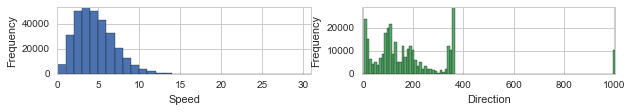

In [5]:
plot_speed_and_angle_distribution(df.speed, df.dir)

In [6]:
# Dir [10,360]=> [0,350]
df['dir'] = df['dir'].apply(lambda x: x%360 if x < 999 else x) 
# Convert Windrose coordianates to Polar Cooridinates 
df['dir_windrose'] = df['dir']
df['dir'] = df['dir'].apply(lambda x: (90 - x)%360 if x < 999 else x)
df.describe()

date           HrMn            dir          speed  \
count  3.170500e+05  317050.000000  317050.000000  317050.000000   
mean   2.004365e+07    1142.838628     206.697896       4.453821   
std    8.735495e+04     692.900475     187.362353       2.412584   
min    1.980010e+07       0.000000       0.000000       0.000000   
25%    1.999111e+07     530.000000      80.000000       2.600000   
50%    2.007010e+07    1130.000000     200.000000       4.100000   
75%    2.011071e+07    1730.000000     310.000000       6.200000   
max    2.015123e+07    2350.000000     999.000000      30.300000   

        dir_windrose  
count  317050.000000  
mean      154.166308  
std       182.773968  
min         0.000000  
25%        40.000000  
50%       110.000000  
75%       190.000000  
max       999.000000

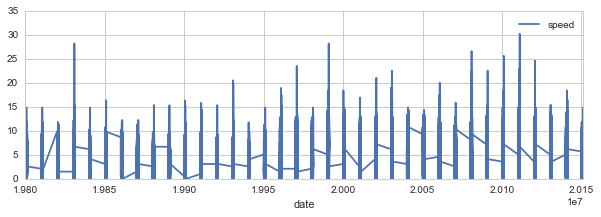

In [7]:
df.plot(x='date', y='speed',legend=True,figsize=(10,3))

### 1.2.1 Unit Detection

True


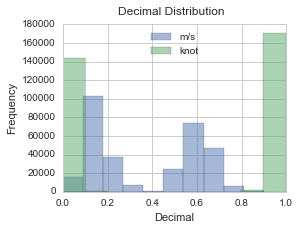

In [8]:
df['decimal'] = df.speed % 1
df.decimal.hist(alpha=0.5, label='m/s', figsize=(4, 3))
knot_unit = True if len(df.query('decimal >= 0.2')) / len(df) > 0.3 else False

# knot_unit = False

if knot_unit:
    df['speed'] = df['speed'] * 1.943845
    df['decimal'] = df.speed % 1
    df.decimal.hist(alpha=0.5, label='knot')
    # need more elaboration, some is not near an integer
    df['speed'] = df['speed'].apply(lambda x: int(round(x)))
plt_configure(xlabel='Decimal', ylabel='Frequency', legend={'loc': 'best'}, title='Decimal Distribution')

print knot_unit

### 1.2.2 Sampling Type Selection

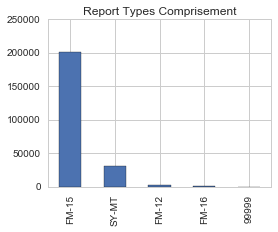

In [9]:
sample_type = df.query('date > 20000000')['type']
sample_type.value_counts().plot(
    kind = 'bar', title = 'Report Types Comprisement', figsize=(4,3))

report_type_most_used = sample_type.value_counts().argmax()
df = df.query("type==@report_type_most_used")

### 1.2.3 Sampling Time Selection

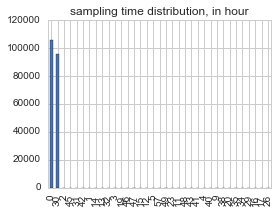

In [10]:
df['sample_time'] = df.HrMn % 100 
sample_time = df.query('date > 20000000')['sample_time']
sample_time.value_counts().plot(
    kind = 'bar', title = 'sampling time distribution, in hour', figsize=(4,3))

# Need more elaboration
sample_times = sample_time.value_counts()[sample_time.value_counts() > 1000]
sample_times = sample_times.index.tolist()
df = df.query("sample_time in @sample_times")
df.drop(['sample_time'], 1,inplace=True)

In [11]:
df['HrMn'].value_counts().sort_index()

0        757
30      3992
100     7217
130     4000
200     7239
230     3997
300     2652
330     3994
400     7248
430     3999
500     7243
530     4003
600      755
630     3994
700     7230
730     3995
800     7245
830     3999
900     2674
930     3992
1000    7236
1030    3999
1100    7224
1130    3994
1200     786
1230    4001
1300    7229
1330    3995
1400    7216
1430    3992
1500    2735
1530    3989
1600    7189
1630    3977
1700    7212
1730    3994
1800     824
1830    3984
1900    7189
1930    3995
2000    7200
2030    3997
2100    2698
2130    3991
2200    7205
2230    3987
2300    7212
2330    3979
Name: HrMn, dtype: int64

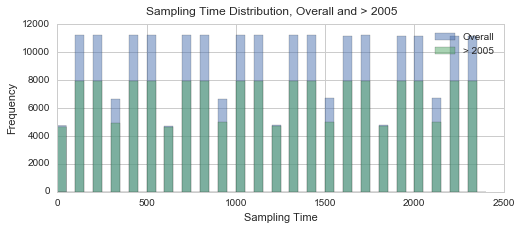

In [12]:
MID_YEAR = (min(df.date)//10000+max(df.date)//10000)//2
bins=arange(min(df.HrMn), max(df.HrMn) + 100, 50)

df['HrMn'].plot(
    kind='hist', alpha=0.5,bins=bins, label='Overall')

df.query('date > @MID_YEAR * 10000')['HrMn'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' %  MID_YEAR )

plt_configure(xlabel='Sampling Time', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3), 
              title = 'Sampling Time Distribution, Overall and > %s ' %  MID_YEAR)

## 1.3 Data Wrangling

### 1.3.1 Artefacts

#### 1.3.1.1 wrong direction record

In [13]:
display(df.query("(dir % 10 >= 0.1) & (dir != 999)"))
df = df.query('(dir % 10 <= 0.1) | (dir == 999)')

Empty DataFrame
Columns: [date, HrMn, type, dir, speed, wind_type, dir_windrose, decimal]
Index: []

#### 1.3.1.2 sudden increase in speed

date  HrMn   type  dir  speed wind_type  dir_windrose   decimal  \
111486  19990916   200  FM-15  110     50         N           340  0.956817   
259838  20101116  1930  FM-15   70     50         N            20  0.956817   
111485  19990916   100  FM-15  120     49         N           330  0.984894   
289552  20120723  1700  FM-15   20     48         N            70  0.012971   
289551  20120723  1630  FM-15   30     47         N            60  0.041049   
111488  19990916   400  FM-15  100     46         N           350  0.069127   
289556  20120723  1900  FM-15  340     44         N           110  0.930897   
222027  20080923  1600  FM-15    0     44         N            90  0.930897   
239166  20090914  1930  FM-15  340     44         N           110  0.930897   
289553  20120723  1730  FM-15   10     43         N            80  0.958975   

        incre  incre_reverse  
111486    1.0            4.0  
259838   39.0           38.0  
111485   11.0           -1.0  
289552    1.0            5.0  
289551    6.0           -1.0  
111488   -4.0            5.0  
289556    2.0            3.0  
222027    2.0            4.0  
239166    2.0            3.0  
289553   -5.0            1.0

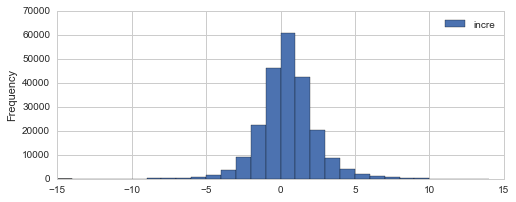

In [14]:
# sudden increse
df['incre'] = df.speed.diff(1)
df['incre'].fillna(0, inplace=True)
df['incre_reverse'] = df.speed.diff(-1)
df['incre_reverse'].fillna(0, inplace=True)

display(df.sort_values(by='speed',ascending=False).head(10))
df['incre'].plot(kind='hist', bins=arange(-15, 15), legend=True, figsize=(8, 3))

In [15]:
incre_threshold = 20 if knot_unit else 10
print 'sudden increase number', len(df.query('(incre > @incre_threshold )&(incre_reverse > @incre_threshold )'))
df = df.query('(incre < @incre_threshold )|(incre_reverse < @incre_threshold )')

sudden increase number 1


After Simple Aretefacts Handling

In [16]:
# Check the max speed
df.sort_values(by='speed',ascending=False).head(10)

date  HrMn   type  dir  speed wind_type  dir_windrose   decimal  \
111486  19990916   200  FM-15  110     50         N           340  0.956817   
111485  19990916   100  FM-15  120     49         N           330  0.984894   
289552  20120723  1700  FM-15   20     48         N            70  0.012971   
289551  20120723  1630  FM-15   30     47         N            60  0.041049   
111488  19990916   400  FM-15  100     46         N           350  0.069127   
239166  20090914  1930  FM-15  340     44         N           110  0.930897   
289556  20120723  1900  FM-15  340     44         N           110  0.930897   
222027  20080923  1600  FM-15    0     44         N            90  0.930897   
289553  20120723  1730  FM-15   10     43         N            80  0.958975   
289555  20120723  1830  FM-15  350     42         N           100  0.987052   

        incre  incre_reverse  
111486    1.0            4.0  
111485   11.0           -1.0  
289552    1.0            5.0  
289551    6.0           -1.0  
111488   -4.0            5.0  
239166    2.0            3.0  
289556    2.0            3.0  
222027    2.0            4.0  
289553   -5.0            1.0  
289555   -1.0           -2.0

### 1.3.2 Direction re-aligment and 999
For some dataset, the 16 sectors are not record properly,

e.g. the sectors are [0,20,30,50], need to redistribute the angle into 22.5

In [17]:
display(df['dir'].value_counts().sort_index())
effective_column = df.query('dir < 999')['dir'].value_counts()[df['dir'].value_counts() > 30].sort_index()
SECTOR_LENGTH = 360/len(effective_column)
print len(effective_column), SECTOR_LENGTH

0      13367
10      7823
20      4123
30      3279
40      3021
50      3529
60      5428
70      9209
80     21620
90     19553
100     8578
110     4749
120     1320
130      824
140      518
150      426
160      640
170     1370
180     1797
190     1980
200     2091
210     1704
220     1870
230     3249
240     5370
250     6743
260    11253
270     6410
280     6127
290     6908
300     4285
310     4632
320     5714
330     6776
340    11175
350    18214
999     9578
Name: dir, dtype: int64

36 10.0


In [18]:
df=realign_direction(df, effective_column)

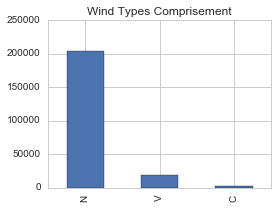

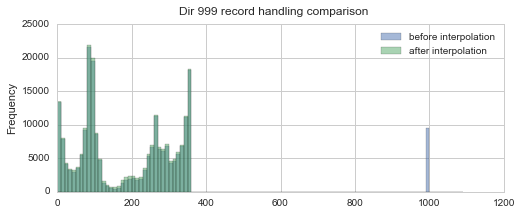

In [19]:
df=fill_direction_999(df, SECTOR_LENGTH)

### 1.3.3 Time Shift Comparison

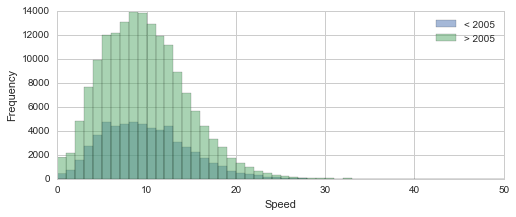

In [20]:
DIR_REDISTRIBUTE = 'even'
if DIR_REDISTRIBUTE == 'even':
    DIR_BIN = arange(-5, 360, 10) 
elif DIR_REDISTRIBUTE == 'round_up':
    DIR_BIN = arange(0, 360+10, 10) 

# Comparison between mid_year, looking for: 
# 1. Odd Even Bias
# 2. Time Shift of Wind Speed Distribution
bins = arange(0, max(df.speed) + 1)
df.query('date < @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['speed'].plot(
    kind='hist', alpha=0.5,bins=bins, label='> %s' % MID_YEAR)

plt.suptitle('Speed Comparison between year < %s, > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Speed', ylabel='Frequency', legend=True, figsize=(8, 3))

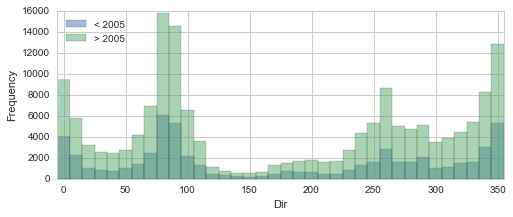

In [21]:
df.query('date < @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='< %s' % MID_YEAR)

df.query('date > @MID_YEAR * 10000')['dir'].plot(
    kind='hist', alpha=0.5,bins=DIR_BIN, label='> %s' % MID_YEAR)

plt.suptitle('Dir Comparison between year < %s, and > %s ' % (MID_YEAR, MID_YEAR), fontsize = 14)
plt_configure(xlabel='Dir', ylabel='Frequency', legend={'loc':'best'}, figsize=(8, 3),tight='x')

1995 - 1999


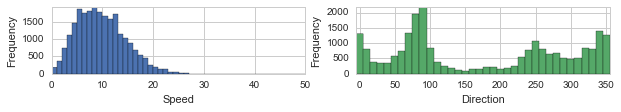

2000 - 2004


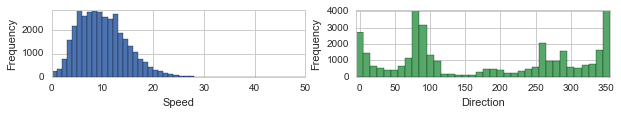

2005 - 2009


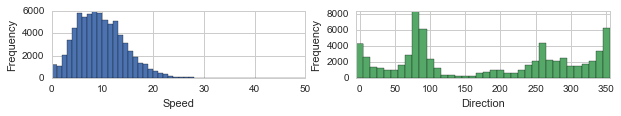

2010 - 2014


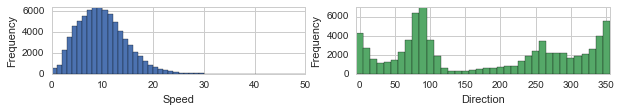

2015 - 2015


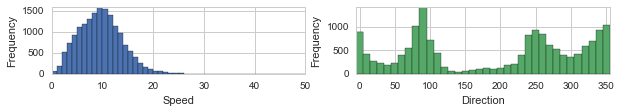

In [22]:
# Inspect the time shift of speed and degree distribution, and odd-even bias
check_time_shift(df)

### 1.3.4 0 Speed

In [23]:
with_too_many_zero, null_wind_frequency = is_with_too_many_zero(df.query("(date >= 20050000)"))
delete_zero = with_too_many_zero
if delete_zero:
    df = df.query('(speed > 0)')
print delete_zero, null_wind_frequency

False 0.0108815568162


## 1.4 Re-distribute Direction and Speed
e.g. Dir 50 -> -45 ~ 55, to make KDE result better

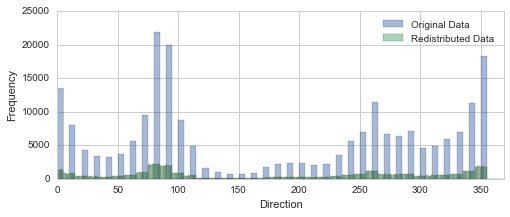

In [24]:
# Randomize the angle degree, to form a better KDE estimation
df = randomize_angle(df, DIR_REDISTRIBUTE, SECTOR_LENGTH)

Redistribute upward, e.g. 0 -> [0,1]


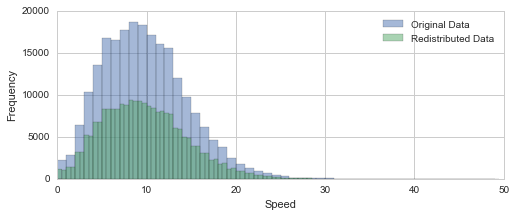

In [25]:
contain_zero = not delete_zero
df, speed_redistribution_info = randomize_speed(df, contain_zero)

## 1.5 Generate (x,y) from (speed,dir)

CPU times: user 1.73 s, sys: 33.7 ms, total: 1.77 s
Wall time: 1.77 s


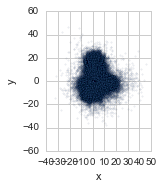

In [26]:
%%time
# There might be a small dot in the centre, which is due to too many zero (more than 1 speed) in center
# Scatter plot in matplot has performance issue, the speed is very slow
df['x'] = df['speed'] * cos(df['dir'] * pi / 180.0)
df['y'] = df['speed'] * sin(df['dir'] * pi / 180.0)
df.plot(kind='scatter', x='x', y='y', alpha=0.10, s=2, figsize=(2.5,2.5))
plt.gca().set_aspect('equal')

# 2. Re-select Data and Configs

## 2.1 Data Overview

In [27]:
## Summery of the data selection
print 'Knot unit?', knot_unit
print 'Incre_threshold for artefact detection:', incre_threshold
print 'Report type used:', report_type_most_used
print 'Sampling time used:', sample_times
print 'delete_zero?', delete_zero
if 'speed_redistribution_info' in globals():
    print 'Speed redistribution info:', speed_redistribution_info 

df_all_years = df # for later across-year comparison
df = df.query('(date >= 20100000) & (date < 20150000)')
df.describe()

Knot unit? True
Incre_threshold for artefact detection: 20
Report type used: FM-15
Sampling time used: [0, 30]
delete_zero? False
Speed redistribution info: Redistribute upward, e.g. 0 -> [0,1]


date          HrMn           dir         speed  dir_windrose  \
count  7.647300e+04  76473.000000  76473.000000  76473.000000  76473.000000   
mean   2.012144e+07   1181.018529    174.910728      9.929550    163.000000   
std    1.426976e+04    691.398080    119.703546      4.771125    206.904427   
min    2.010010e+07      0.000000     -4.999124      0.000627      0.000000   
25%    2.011042e+07    600.000000     76.292420      6.413647     40.000000   
50%    2.012082e+07   1130.000000    139.675251      9.515857    110.000000   
75%    2.013111e+07   1730.000000    289.141382     12.847710    190.000000   
max    2.014123e+07   2330.000000    354.997688     48.230247    999.000000   

            decimal         incre  incre_reverse             x             y  
count  76473.000000  76473.000000   76473.000000  76473.000000  76473.000000  
mean       0.552319     -0.000458      -0.000523      2.979542      1.478547  
std        0.448585      1.783864       1.784161      5.861574      8.714293  
min        0.000000    -38.000000     -39.000000    -27.513403    -30.445541  
25%        0.053997     -1.000000      -1.000000     -1.011489     -4.652937  
50%        0.913609      0.000000       0.000000      2.217664     -0.127240  
75%        0.967607      1.000000       1.000000      6.622107      7.861213  
max        0.997842     28.000000      18.000000     46.011899     34.453170

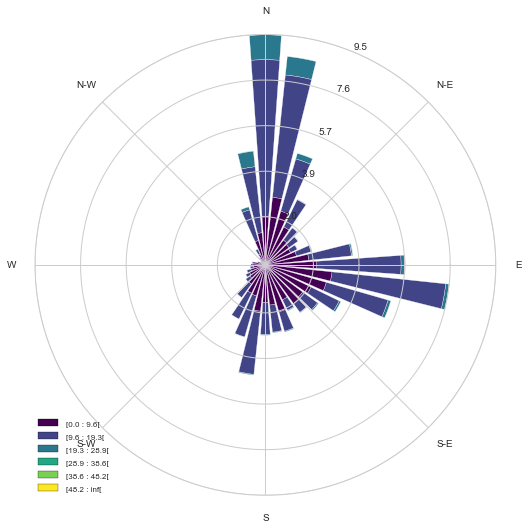

In [28]:
# 90 degree is in east
ax = WindroseAxes.from_ax()
viridis = plt.get_cmap('viridis')
ax.bar(df.dir_windrose, df.speed, normed=True, opening=0.8, edgecolor='white', nsector=36, cmap=viridis)
ax.set_legend()

In [29]:
ax, _params = WindAxes.from_ax().pdf(df.speed, bins=arange(0, max(df.speed)))
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)
plt_configure(figsize=(4,3),xlabel='V',ylabel='PDF')

fig,ax = plt.subplots()
ecdf = sm.distributions.ECDF(df.speed)
x = linspace(0, df.speed.max())
y = ecdf(x)
plot(log(x), log(-log(1-y)),'o', label='ECDF')

k_shape, lamb_scale = weibull_params[1], weibull_params[3]
y=1-exp(-(x/lamb_scale)**k_shape) # cdf
plot(log(x), log(-log(1-y)),'-', label='Weibull')
plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'},figsize=(4,3))
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARwAAADZCAYAAADypo9TAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzt3XtcVAX+//HXDDcFRLxR5hVR8EJqiqnrV7MlTcvWVCi8
5PqNb2317ZFfczdFLU0zdWvbLivbxbZ+oamZllqalqipWYIKIioXQRFEUFG5isCc3x8DIya3GWfm
zOXzfDx6MHBm5ryH9OOZOee8j0ZRFAUhhLACrdoBhBDOQwaOEMJqZOAIIaxGBo4Qwmpk4AghrEYG
jhDCalwt+eSKorBo0SJSUlJwd3dn6dKldOrUybA8NjaW6OhoXF1dmTRpEuHh4dy4cYOoqCiys7Px
9vZm4cKFdO7c2ZIxhRBWYtGB89NPP3Hjxg3WrVtHYmIiy5YtIzo6GoDKykqWL1/Opk2b8PDwYPLk
yYSGhrJ9+3a8vLxYv349mZmZvP7663z66aeWjCmEsBKLDpzDhw8zfPhwAPr168fx48cNy06fPk2X
Ll3w9vYGICQkhEOHDpGens6IESMA8Pf3JyMjw5IRhRBWZNHPcIqLi2nRooXhe1dXV3Q6XZ3LPD09
KS4upnfv3uzZsweAhIQE8vPzkYOhhXAMFt3C8fb2pqSkxPC9TqdDq9UalhUXFxuWlZSU4OPjQ2ho
KOnp6UydOpUBAwbQp08fNBpNg+s5fPiwZV6AEKJRAwcObPJ9LTpwBgwYwO7duxkzZgwJCQkEBgYa
lgUEBHD27FkKCwtp1qwZ8fHxREZGkpSUxNChQ4mKiuL48eOcP3++Sesy5kWr7fDhw3aVFySzNdhb
XjD+H3uLDpxRo0Zx4MABIiIiAFi2bBnfffcdZWVlhIeHExUVxdNPP42iKISFheHn54ebmxvvvfce
H374IT4+PixdutSSEYUQVmTRgaPRaHj99ddv+Zm/v7/h9siRIxk5cuQty1u1asVnn31myVhCCJXI
gX9CCKuRgSOEsBoZOEIIq5GBI4SwGhk4QgirkYEjhLAai+4Wd0ZVVVWcPn3a8H1AQAAuLi4qJhLC
dsjAMbPTp08TFJQJ+AOZpKToh07tIVRVVaVaPiHUJG+pLMIfCKz+enMIBQVBUFAm2dnZqqYTQi0y
cKzm1iEkhDOSgSOEsBqbqxitrKxkzpw55OTk4OrqypIlS245/8ouuF4HrkOlAjRcrSGEM7HoFk7t
itHZs2ezbNkyw7KaitHPP/+cmJgY1q9fT0FBAXv37kWn07Fu3TpeeOEF/vnPf1oyolldLLnI4vjF
EDUQFjSHV4N5af9L5Jbkqh1NCJtgMxWjAwcOJC4uju7du1NVVYWiKBQVFeHm5mbJiGaz8/ROwjeE
U1heCNc6QUEv8Mlgh8sO9uXug/vmwdH5gH4vVWpqquGxsutcOAuLDpz6Kka1Wu1ty7y8vCgqKsLL
y4vs7GzGjBnD1atX+eijjywZ8Y5VVVWx7fA2Jv84mQpdBVH9o1g2aQpUBQMpLNv+DSuOrqB0/AK4
0QOS+5OXl3fbrvPa5WRCOCqbqxj9/PPPGT58OLNmzSIvL4/p06ezdetW3N3dG1yXWjWjCekJ/M+v
88C3BDbM455W7aGqJquGwNJAXu38KrOTX4MJ06GwpuunZq8VHD9+nKKiIjXiG8Ueq1ztLbO95TWW
zVWMpqenG95GtWjRgsrKSkPxekPUqmacc3QO+ObDrqWQHEaPHpm3LA8ODiaYYGYv9IWpz0LEi5To
XrntPra+hWOv9Zf2lNne8oIDVIzOmDGDefPmMXXqVCorK5k9ezbNmjWzZEyT7T2zl105u+BsCOyL
AtLqv/Pp/4Jdb8KoOWwp3QJMsFZMIWyGzVWMenp68u6771oyllnoFB2zd87Wf7NzDk3a/X1wFvRb
xUG/g9AxAbJte6tGCHOTA/9MtDZpLYdzDzOuyzjI6du0B+nc4LtFKCjw6CLQyDlVwrnIwDGBoigs
+XkJ7i7uzOo7y7gHZ4Vwv8f90P4k9PnKMgGFsFEycEwQmxlLyuUUnuzzJB29Oxr9+LHNx4LOBYa/
CZrGPxAXwlHIwDHBv+P/DcALg14w6fFtXdpC0qNw13EIjDVnNCFsmgwcI+UU5vDtqW/pf3d/BncY
bPoT7f+L/uuID+Xa6cJpyMAx0idHPqFKqeKFkBcaveZ5gy52hxMToUMSv+b9ajjdoeY/KekSjkgG
jhF0io5VR1bh4+HDlHun3PkT/vI3ANamr72tpKt2Q6AQjkIqRo3wy7lfyCnK4en+T+Pl7nXnT5g9
GC70ZJdmF/ll+dQ+3UEIRyRbOEb4+sTXAIT3CTfTM2ogPoJKpZKNGRvN9JxC2C4ZOE2kU3R8feJr
fNx86FjR0Xyfsxx7DE9XT75K/0oOBBQOz+Ya/7755hs2bdqERqOhvLycU6dOceDAAUNvjlp+y/6N
nKIcODqKe+e7U1MrccduePNY18dYn74eevwMqb3M8KRC2Caba/ybMGECMTExfPHFF/Tp04cFCxao
PmwANpzYoL9xIgxzl6E/GfCk/ka/b8z2nELYIosOnKY2/rm5uRka/2okJSWRnp5OeLi5Pi8xnaIo
fH3ia1q4tYCMP5j9+Xu36k13n+4QtBuaXTX78wthKyw6cOpr/KtrWU3jX42PP/6YF1980ZLxmiwx
L5FzhecYec/IWuVa5qPRaPhT1z+B6w3oJR8eC8dl0YFjSuMfQFFREWfOnOH++++3ZLwm25G+A4AR
94yw2DrGdR2nv9F3tcXWIYTabKbxLy4ujsjISADi4uIYMmSIUeuyZDXj1wn63eFtrra55ec33yIG
G36WlpZG7c936rrP7xnuc2YQ+O+Bluc5frzA5mpH7bH+0t4y21teY9lM4194eDh+fn4AZGZm3rI3
qyksVc1YfKOYxG2JDGg/gGH9h92yLDj49iHSo0ePRu/ze4b7LP0TdI2De78jOPhZm6odtdf6S3vK
bG95wcYqRk1p/AMMWzq2YHfmbip0FTwc8LDlV3biYXh0MfTZDjxr+fUJYWVy4F8jdpzWf35jlYFz
vSVkPATtT5BVlGX59QlhZTJwGrHj9A5auLdgaKeh1lnhiTD9es/tsM76hLAiGTgNyLiSQXpBOn/0
/yPuLubfHV6nU+NB5yIDRzgkGTgNiM3Qt/H19e5rvY6asjaQOYSkgiTOXj1r+fUJYUUycBqwLXkb
AEsiBxEUlElWlpU+V0keA8DGk3IQoHAsMnAaEJcfB2Ut4eKjmPPcqUadegitRsvqI6ulAVA4FBk4
9Th37RzZJdlwdiAoVv41lbamj3cfjl5MIGjgRWkAFA5DBk499mXt0984O0iV9Q9tPRQ0CgSexKpb
V0JYkAyceuw7WzNwQlRZ/5BW1ad2BG1WZf1CWIIMnHr8nPUznq6ecKG3Kuu/p9k9kN8Duv0EbqWq
ZBDC3GTg1OFiyUVOXDzBgLYDQKdiz/ypUHC7DgEH1MsghBlZdOAoisLChQuJiIhg+vTpnDt37pbl
sbGxhIWFERERwYYNGww///jjj4mIiGDSpEls3Gj9XcP7s/YDEOKnztspg5RQ/deeu9TNIYSZWPSf
79oVo4mJiSxbtozo6GjgZsXopk2b8PDwYPLkyYSGhpKens7Ro0dZt24dpaWl/Oc//7FkxDodzD4I
oN/CUdP5YChqD4G7qdLJbnFh/2ymYjQkJIRDhw6xf/9+AgMDeeGFF3j++ed58MEHLRmxTr9m/4pW
oyW4dePVEhalaCHlMfC8SuLlRHWzCGEGNlMx6unpSXFxMVeuXOH48eO8//77LFq0iNmzZ1sy4m0q
dZXEn48n2C8YLzczXOzuTqU9CsCe83tUjSGEOVj0LZUpFaO+vr4EBATg6uqKv78/Hh4eFBQU0Lp1
6wbXdadNaVV

## 2.2 Create input data, i.e. speed_set

In [30]:
# speed_set = array(zip(-df.x, -df.y)) # Adjust the direction to match for Cook's paper
SPEED_SET = array(zip(df.x, df.y))
if 'params' not in globals():
    NUMBER_OF_GAUSSIAN = 3
    FIT_METHOD = 'square_error'
    KDE_GRIDSEARCH = True
DEFAULT_BANDWDITH = 1.5 if knot_unit else 0.7
fig_list = []

In [31]:
FITTING_RANGE = []
fit_limit = ceil(df['speed'].quantile(.95))
fitting_axis_range = arange(-fit_limit, fit_limit+1, 1)
print fitting_axis_range

for i in fitting_axis_range:
    for j in fitting_axis_range:
        FITTING_RANGE.append([i,j])

[-19. -18. -17. -16. -15. -14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.
  -4.  -3.  -2.  -1.   0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.
  11.  12.  13.  14.  15.  16.  17.  18.  19.]


In [32]:
plot_limit = ceil(df['speed'].quantile(.95))
PLOT_AXIS_RANGE = arange(-plot_limit, plot_limit+1, 1)

# 3. Kernel Density Estimation

In [33]:
sample = SPEED_SET
KDE_KERNEL = 'gaussian'
# KDE_KERNEL, bandwidth = 'tophat', 1

In [34]:
%%time
# The bandwidth value sometimes would be too radical
from sklearn.grid_search import GridSearchCV

if KDE_GRIDSEARCH == True:
    if knot_unit:
        bandwidth_range = arange(0.5,2,0.2)
    else:
        bandwidth_range = arange(0.4,1,0.1)

    grid = GridSearchCV(neighbors.KernelDensity(kernel = KDE_KERNEL),
                        {'bandwidth': bandwidth_range},
                        n_jobs=-1, cv=4) 
    grid.fit(sample)
    bandwidth = grid.best_params_['bandwidth']

CPU times: user 419 ms, sys: 85.2 ms, total: 504 ms
Wall time: 6min 18s


In [35]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH

# bandwidth = 1.9
kde = neighbors.KernelDensity(bandwidth=bandwidth,kernel = KDE_KERNEL).fit(sample)

points = FITTING_RANGE
# very slow if the dataset is too large, e.g. 100,000
# kde returns log prob, need to convert it
kde_result = exp(kde.score_samples(points))
print 'bandwidth:', bandwidth, len(kde_result)
print kde_result[:5]

bandwidth: 1.3 1521
[  5.14803918e-11   4.30438423e-10   3.13302825e-09   2.38098962e-08
   1.41794305e-07]


In [36]:
# Plot jPDF
X = Y = PLOT_AXIS_RANGE
# Can't work if pass as generate_Z_from_X_Y(X,Y, exp(kde.score_samples())), need to use lambda
# see http://stackoverflow.com/questions/21035437/passing-a-function-as-an-argument-in-python
kde_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(kde.score_samples(coords)))
colorbar_lim = 0, kde_Z.max()

plot_3d_prob_density(X,Y,kde_Z)

fig_kde,ax1 = plt.subplots(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x', ylabel='y',ax=ax1)

with sns.axes_style({'axes.grid' : False}):
    from matplotlib import ticker
    fig_hist,ax2 = plt.subplots(figsize=(4,3))
    _,_,_,image = ax2.hist2d(df.x, df.y, bins=PLOT_AXIS_RANGE, cmap='viridis',)
    ax2.set_aspect('equal')
    cb = plt.colorbar(image)
    tick_locator = ticker.MaxNLocator(nbins=6)
    cb.locator = tick_locator
    cb.update_ticks()
    plt_configure(ax=ax2, xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAUEAAAFBCAYAAADpDh0xAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXu0HFWZNv5U9f1yzklCALkHAVExEQ0wCPoNDqgwzueA
IUoiyUBkBtQ4DqiD6M+AAwFHncX6ZhRFQR1QPiEj4OVzKTKMiIqAiYgEEi6BALmQ6zl97+rqqt8f
fd46u3bvqtpVXdWn+5x61mKR011Vvbu66qn3+ryKaZomYsSIEWOWQp3uBcSIESPGdCImwRgxYsxq
xCQYI0aMWY2YBGPEiDGrEZNgjBgxZjViEowRI8asRkyCMWLEmNWISTBGjBizGjEJxogRY1YjJsEY
MWLMasQkGCNGjFmNmARjxIgxqxGTYIwYMWY1YhKMESPGrEZMgjFixJjViEkwRowYsxoxCcaIEWNW
IybBGDFizGrEJBgjRoxZjZgEY8SIMasRk2CMGDFmNWISjBEjxqxGTIIxYsSY1YhJMEaMGLMaMQnG
iBFjViMmwRhdME0ThmHANM3pXkqMGJEjOd0LiDFYMAwDuq6j0WhAURTr9Xw+j0QiMY0rixEjGsQk
GMNCvV5HuVxGNpuFqqowTRP1eh3tdhuGYUBVVSSTSev/MSnGmAmISTAGTNNEu91Gq9VCu91Gs9m0
SM8wDACwrEJd12GaJprNJlRVRSKRiEkxxlBDMePAz6wGub+GYaDZbKJWqwm3UxQFiUTC+k9Vp8LJ
dAnFpBhjGBGT4CyGrutot9sAgGaziWq1CgBIJBLI5XJot9toNBrCBElMijFmCmISnIUwTdNGgLVa
Dc1m03o/l8shmUzaYoL5fN5ym+k/FkSKFDNkSVHTNGiahlwuh0wmE5NijIFCHBOcZTAMA61WyyK0
SqUCwzCQSCSQyWRc3WGy7ICpMhqWFHVdh67rAKaswEQiYVmGRL5xTDHGICEmwVkC1oojEiLCy2Qy
yOfzFoHJgHWH6fg8KRLhEujfiUQCiqK4kmI6nbaV6MSIERViEpwF0DQNuq5bZS/VahWtVguKoqBQ
KCCdTvf8GW6kyFqe5EazlqIXKSYSCaRSqZgUY0SCmARnONrtNiYmJqDrOkZGRlCtVmEYBpLJJIrF
oi12RwgjTMyToqZpSKfTFhkahmGzFN1IsdVqodFooNVqIZFIIJ/Px6QYIzTEJDhDwbu/AFAulwF0
Eh/ZbFaKRGgb0zR7Jh2K/fHrkyVFTdOspEuj0YgtxRihICbBGQi29o/cUqBDaMViEalUappX2FlL
Mpn0RYq0He3PW4oxKcYIgpgEZxgoSwt0EhHVatUijtHRUdcM7HSShgwp0uvValXKfaYkS0yKMdwQ
k+AMgVvtH7W/DRMJiEiRirnp+7CWIl+4rSiKbRtKtLD1jHFJTgwgJsEZAbb2zzAMVCoVtNttqKqK
YrGIer1uWVIyoPjfINXRE4Grqios3OYLuEXdLKxCTjqdtoQiiGyH6SERIzzEJDjkYK0/TdMsa4lq
/xRFGZibO0xS9XKfnUiRBWspUjF4TIqzDzEJDik0TUO9Xrdcu2q1Ck3TAACFQgGZTGaaVziFfpCJ
GynSg4IlRdaNZi3FmBRnH2ISHEKQsEGtVkM2m7Vq/xKJBIrFomOsy8sSm0k3OUuKmUzGKtwmQjRN
03poAM7uc0yKMx8xCQ4R+K4LAGg0GgCAbDaLXC4nvDHjmxUWgSmKgna7jVQqBVVVfccUiRRp+2w2
i2w2a2WoYwwfYhIcEvC1f0R+AFAsFkNpfROBLZaeCWBlvlKplFUzyfc9e5EikWEikbCSTvReKpWK
SXGIEJPgEID6b4FOIqRSqVg3czabDZ0ATdOcMaQnC7IUZUiRTTZRGIIvyQGmiJPKcWJSHEzEJDjA
4Gv/6vW6ZQGm02lomubrxvJDbINWItNvsKRIDwVR8bamaZZFyBZus6RIsUd+PktMioOBmAQHFHzt
X7VatZRgisWiFdgPu+wE6JAlJQNmMxESiNRYUiTyI2UeVkuRV92m/YlAWVKkBA6vzh2jf4hJcADB
Wn9s61s6nUY+n4eqqjadPi/4tTio9Yx/jYhgtoM9n6SUzVuKbqRI55DCHM1mE5lMxla8HVuK/UNM
ggMEXddRLpehqqql8kytb/l8HplMxroxgtwgXlYdWSimaVry+iwZk3U4HXGuQbZIRZaim+o2S4rs
92ItRdomJsXoEZPggIAu/kajgVQqhWaziXa73XPtnwxM07QRLmn2GYaBRqMBXddtpOgko9+PG3UY
iEBGdZs9hwCsf/OWYkyK0SMmwWmGSPePXFG29a0XuO1Pc0ao15jmDfP7UtmHl4x+v0lxGOBXddvN
fdZ1PSbFkBGT4DSCr/2r1+vWe161f2Fc8OyYzUwmg1wuh/Hxcdd9RDe0mw4ga8EOskvbTzipbgMQ
WopODxaWFOnvZDJpxY1jUpRDTILTBLb2j536BnSyhlEUP7NT31j3l3qNneYLs/uK3vcSMiBomma5
+KzkVT8xqETMq277tbYpdEFhC9ZSpO6YmBTFiEmwz+Br/xqNhmUBZrNZNBqNyGr/ALv76xVvDAIR
KTabTSu7zBMjuXJsKUk/0OvnsArXYR/H7yQ/nuBElmJMis6ISbCP4N3fSqVikUOxWEQymbS1w7nB
zwVM27ZaLVQqFQDu8cawaw8TiQR0XUc6nUYikfBdSjLbIUOKBF3XUavVXN1nfpIfFXHPVlKMSbBP
YK0/tvUtlUqhUChYtWZA+C4bHY93f6cDbp0YRIg8KdJNGqMDESm2Wi3L4vMaWsUnWprNpmXBs4mW
2YKYBCMG1f4lEgmk02lb61s/av9Idgvo3AwjIyNSF3i/NAD91NcBU9Z0nA2dAlvETqIQfif5AbBm
PpdKJRiGYV0rM50UYxKMENQ3SnLujUbDJntPcTMeMpagDAGw2V8AluRTL8eMEm5un0hBZyaU44QV
W2QRZJIfex7pvNMDiHWfZ6KlGJNgBBDp/lEZQzqdRqFQiPSG5bO/mUzGcnmGCSwpplIp25Q5p3Kc
fmWeBzXLLIJfUiRQ8oyd5EeJrplEijEJhgw2+QHAVvsnE4vze+PyN6Mo+0tPcz/HHNSbXFEU6xz6
HbYUBSkOyoPFj0UpQ4rAlGCv6DzOJFKMSTBEkNtGFxVf+yebjAhKQHzxM2V/KaY2qMQWFE43MztT
hC/HiSr5NMzgzyMJdvCxRYIsKfJxykFFTIIhgK/9azabqNVqAPy7okG2cyp+DgPDpCzN38yiJAuB
7c2eznKcKGKCYaBXi5vuiWq1avWiP/zwwzjooIPw5je/ebq+lhAxCfYIvvavWq1aaiuFQsESQ/BD
In62NQwDpVLJtfg5SE1hFOg3kYrKcRqNhmWdO5XjDGOSJUoy9Xq4OJEiPViIFB999FEsXLjQkQRN
08Q111yDzZs3I51OY+3atTjiiCOs9x944AHcdNNNSCaTWLJkCZYuXeq4z3PPPYc1a9YAAI466iis
XbsWqqpi7dq12LBhAwqFAgB0jhf6GZtF4Gv/aOpbMplEsVjsi3VBN3RYYgtRYBDWROU4iURnJkg2
m7V1sEy3Os4gwTRN12vXzygCoHNv/M///A/q9Tqy2azjce+//35omoYf/OAH+NOf/oQbbrgBN910
k3WML37xi7j77ruRyWSwbNkynHnmmVi/fr1wnxtvvBGf/OQnsXjxYlx11VV44IEHcNZZZ2Hjxo24
9dZbMWfOHOtzYxIMgFarhUajYd0obOtbLpezbjAWslaQjJozub8EWfdXdg3UezqTEaQ1jS8jidGB
EymSkfDMM8/g05/+NADgZz/7GX784x/jne98J97//vfbrrP169fjHe94BwDgzW9+M5588knrveef
fx5HHXUUisU

In [37]:
kde_cdf = cdf_from_pdf(kde_result)

# 4. GMM by Expectation-maximization

In [38]:
sample= SPEED_SET
clf = mixture.GMM(n_components=NUMBER_OF_GAUSSIAN, covariance_type='full')
clf.fit(sample)
print clf.converged_

True


In [39]:
gmm_em_result = read_gmm_em_result(clf)
pretty_print_gmm(gmm_em_result)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.362   1.196  10.740  3.304  5.721  -0.162
2  0.320   8.741  -1.445  5.020  3.473  -0.033
3  0.319  -0.773  -6.090  4.376  5.083   0.036

GMM Plot Result
0.36150029678 [[  1.19574862  10.74029884]] [ 3.23940245  5.75808514] -172.16607755
0.319611345522 [[ 8.74149702 -1.44517037]] [ 3.46954769  5.02267861] -92.5043697668
0.318888357698 [[-0.77332002 -6.09047415]] [ 4.36463868  5.09245474] 173.221719085


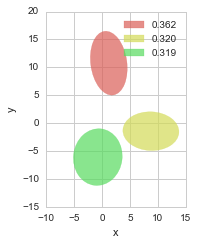

In [40]:
fig,ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm_em_result, ax=ax)

In [41]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, lambda coords: exp(clf.score_samples(coords)[0]))

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = exp(clf.score_samples(points)[0])
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig_em = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y', colorbar_lim=colorbar_lim)
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAUEAAAFBCAYAAADpDh0xAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmUHNV5Nv5UdVfvPTMSQoBAbAKDDRIyMoRAsHGQE3Dy
xYBQjBQkA/ECMXwxEH6YnGNBPpDlQBxOPjvEGBHzGZtYEFb7OF4INnYMNjYyEMuRWARCloSW0Sw9
3dW1dNXvj563+tbt2rt6pnumnnN0NDN969at6qrnvvsrmKZpIkGCBAlmKcTpXkCCBAkSTCcSEkyQ
IMGsRkKCCRIkmNVISDBBggSzGgkJJkiQYFYjIcEECRLMaiQkmCBBglmNhAQTJEgwq5GQYIIECWY1
EhJMkCDBrEZCggkSJJjVSEgwQYIEsxoJCSZIkGBWIyHBBAkSzGokJJggQYJZjYQEEyRIMKuRkGCC
BAlmNRISTJAgwaxGQoIJEiSY1UhIMEGCBLMaCQkmSJBgViMhwQQJEsxqJCSYIEGCWY2EBBMkSDCr
kZBgggQJZjUSEkzQBtM0YRgGTNOc7qUkSNB1pKd7AQl6C4ZhQNd11Ot1CIJg/b1QKCCVSk3jyhIk
6A4SEkxgQZZlVCoV5HI5iKII0zQhyzIajQYMw4Aoikin09b/CSkmmAlISDABTNNEo9GApmloNBpQ
FMUiPcMwAMCSCnVdh2maUBQFoigilUolpJigryGYieFnVoPUX8MwoCgKarWa4zhBEJBKpax/otgy
J9MjlJBign5EQoKzGLquo9FoAAAURUG1WgUApFIp5PN5NBoN1Ot1RwdJQooJZgoSEpyFME3TRoC1
Wg2Kolif5/N5pNNpm02wUChYajP9Y0GkSDZDlhRVVYWqqsjn88hmswkpJugpJDbBWQbDMKBpmkVo
ExMTMAwDqVQK2WzWUx0myQ5ohdGwpKjrOnRdB9CSAlOplCUZEvkmNsUEvYSEBGcJWCmOSIgIL5vN
olAoWAQWBKw6TPPzpEiES6CfU6kUBEHwJMVMJmML0UmQoFtISHAWQFVV6Lpuhb1Uq1VomgZBEFAs
FpHJZDo+hxcpspInqdGspOhHiqlUCpIkJaSYoCtISHCGo9FoYGxsDLquo1wuo1qtwjAMpNNplEol
m+2OEIeZmCdFVVWRyWQsMjQMwyYpepGipmmo1+vQNA2pVAqFQiEhxQSxISHBGQpe/QWASqUCoOn4
yOVygUiExpim2THpkO2PX19QUlRV1XK61Ov1RFJMEAsSEpyBYGP/SC0FmoRWKpUgSdI0r7C5lnQ6
HYoUaRwdz0uKCSkmiIKEBGcYyEsLNB0R1WrVIo6BgQFPD+x0kkYQUqS/V6vVQOozOVkSUkzghYQE
Zwi8Yv8o/a2fSMCJFCmYm66HlRT5wG1BEGxjyNHCxjMmITkJgIQEZwTY2D/DMDAxMYFGowFRFFEq
lSDLsiVJBQHZ/3opjp4IXBRFx8BtPoDbKZuFrZCTyWSsQhFEtv20SSSIDwkJ9jlY6U9VVUtaotg/
QRB65uWOk1T91Gc3UmTBSooUDJ6Q4uxDQoJ9ClVVIcuypdpVq1WoqgoAKBaLyGaz07zCFqaCTLxI
kTYKlhRZNZqVFBNSnH1ISLAPQYUNarUacrmcFfuXSqVQKpVcbV1+kthMeslZUsxms1bgNhGiaZrW
pgG4q88JKc58JCTYR+CzLgCgXq8DAHK5HPL5vOOLmbyssAhMEAQ0Gg1IkgRRFEPbFIkUaXwul0Mu
l7M81An6DwkJ9gn42D8iPwAolUqxpL45gQ2Wnglgy3xJkmTFTPJ5z36kSGSYSqUspxN9JklSQop9
hIQE+wCUfws0HSETExPWy5zL5WInQNM0ZwzpBQVJikFIkXU2kRmCD8kBWsRJ4TgJKfYmEhLsYfCx
f7IsWxJgJpOBqqqhXqwwxNZrITJTDZYUaVNwCt5WVdWSCNnAbZYUyfbI92dJSLE3kJBgj4KP/atW
q1YlmFKpZBn24w47AZpkSc6A2UyEBCI1lhSJ/KgyD1tLka+6TccTgbKkSA4cvjp3gqlDQoI9CFb6
Y1PfMpkMCoUCRFG01enzQ1iJg1LP+L8REcx2sPeTKmXzkqIXKdI9JDOHoijIZrO24O1EUpw6JCTY
Q9B1HZVKBaIoWlWeKfWtUCggm81aL0aUF8RPqiMJxTRNq7w+S8YkHU6HnauXJVInSdGr6jZLiux1
sZIijUlIsftISLBHQA9/vV6HJElQFAWNRqPj2L8gME3TRrhUs88wDNTrdei6biNFtzL6U/Gi9gMR
BKm6zd5DANbPvKSYkGL3kZDgNMOp7h+pomzqWyfwOp76jFCuMfUb5o+lsA+/MvpTTYr9gLBVt73U
Z13XE1KMGQkJTiP42D9Zlq3P/GL/4njg2Tab2WwW+Xweo6Ojnsc4vdBedQBZCbaXVdqphFvVbQCO
kqLbxsKSIv2eTqctu3FCisGQkOA0gY39Y7u+AU2vYTeCn9mub6z6S7nGbv2F2WOdPvcrZEBQVdVS
8dmSV1OJXiVivup2WGmbTBdktmAlRcqOSUjRGQkJTjH42L96vW5JgLlcDvV6vWuxf4Bd/fWzN0aB
EykqimJ5l3liJFWODSWZCnR6HrbCddzzhO3kxxOck6SYkKI7EhKcQvDq78TEhEUOpVIJ6XTalg7n
hTAPMI3VNA0TExMAvO2NccceplIp6LqOTCaDVCoVOpRktiMIKRJ0XUetVvNUn/lOfhTEPVtJMSHB
KQIr/bGpb5IkoVgsWrFmQPwqG83Hq7/TAa9MDCJEnhTpJU3QhBMpappmSXx+Tat4R4uiKJYEzzpa
ZgsSEuwyKPYvlUohk8nYUt+mIvaPym4BzZehXC4HesCnqgZgmPg6oCVNJ97QFtggdioKEbaTHwCr
5/P4+DgMw7CelZlOigkJdhGUN0rl3Ov1uq3sPdnNeASRBIMQAOv9BWCVfOpkzm7CS+1zqqAzE8Jx
4rItsojSyY+9j3TfaQNi1eeZKCkmJNgFONX9ozCGTCaDYrHY1ReW9/5ms1lL5eknsKQoSZKty5xb
OM5UeZ571cvshLCkSCDnGdvJjxxdM4kUExKMGazzA4At9i+ILS7si8u/jE7eX9rNw8zZqy+5IAjW
PQzbbKkbpNgrG0sYiTIIKQKtgr1O93EmkWJCgjGC1DZ6qPjYv6DOiKgExAc/k/eXbGq9SmxR4fYy
sz1F+HCcbjmf+hn8faSCHbxtkRCUFHk7Za8iIcEYwMf+KYqCWq0GILwqGmWcW/BzHOinytL8y+zk
ZCGwudnTGY7TDZtgHOhU4qZ3olqtWrnozz//PObPn4/TTjttui7LEQkJdgg+9q9arVrVVorFolUM
IQyJhBlrGAbGx8c9g5+jxBR2A1NNpE7hOPV63ZLO3cJx+tHJ0k0y9dtc3EiRNhYixRdeeAGLFy92
JUHTNHHbbbdh27ZtyGQyWL9+PRYuXGh9/swzz+Cee+5BOp3GihUrsHLlStdjXn/9daxbtw4AcMwx
x2D9+vUQRRHr16/H5s2bUSwWAaA5X+x3bBaBj/2jrm/pdBqlUmlKpAt6oeMqttAN9MKaKBwnlWr2
BMnlcrYMlumujtNLME3T89kN04oAaL4bP/rRjyDLMnK5nOu8Tz/9NFRVxbe+9S28/PLL2LBhA+65
5x5rji984Qt47LHHkM1msWrVKpx//vl48cUXHY+5++67ceONN2LZsmW45ZZb8Mwzz2D58uXYsmUL
7r//fgwNDVnnTUgwAjRNQ71et14UNvUtn89bLxiLoFJQkGrOpP4Sgqq/QddAuaczGVFS0/gwkgRN
uJEiCQmvvvoqbrrpJgDAd7/7XTz11FP44Ac/iEsuucT2nL344os499xzAQCnnXYafvOb31ifvfHG
GzjmmGNQKpU

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARYAAADUCAYAAABZGgxEAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnX9QU2f2/98hAYMkaJ0CUlChaEthsQLWbWvXcUaz2n6m
PwXWomUdabWd2p1ZkWq3W8FWxO60686U2m2H7lh1rKjdGXe67XZlSnFqbS0sxQLGVoryQwX8Ykv4
JSTk+wfekNzcX0lukpvkvGYyA7n3eXII5M15znOec1RWq9UKgiAIGQnztwEEQQQfJCwEQcgOCQtB
ELJDwkIQhOyQsBAEITsafxvgLvX19f42gSAEyc7OlnTf/777HFbLNN7rERERyMjIkMssnxCwwgIA
R3af8ngOk2kAer1OBmt8P2/L0A0AQEp6oqSxDaN9AIC5KbFO1wZMJuj0es5xF1p7AACZETMk29na
3AkAmGUZC9j31xPyti2WfK/VMg3TEl/nvf5L51aP7fE1tBQKcOQQFTGYMcwcctpFBCcB7bGEMoy3
IoYngmKPTVxc9F4uIgyB5cQTckAeSwAj1SvwVFS45pLivZDXErqQxxLENIz2iYpKg7UbAGDRWqC2
Dtmez1TF8Y6ZmxKLC609aBjtk+S5tAzdQNrUKRKtJoIB8lgCkJahG6LegJhH0WDttolKakIsZs/Q
ITUhFqkJsU7XuZDqucQnSw/4EsEDCUsQw+et2AsKIyT2sAVGbH4pyyKpMSEiOCBhCTAuSviVCX3Q
G6zdvILCRi5xoVhL6EHCEoBI+aByeStCAsEHI0JCSyM5g8NEcEDCEmTwBWztlz/uIGWcmNdCy6HQ
gYQlhOAThzZNG65GX5U0nrwWQgokLAGE2H98Po9BaAnUpmlz+Jp5CL6OgLiIBXLJawkNSFgCDLHt
Wz7PgctbYQQkLSYGyVF6pMXE2B58AiMloMsHBXFDB78JS2NjI5566ikAwLlz57BkyRIUFBSgoKAA
n376qb/MCjr4BMBeVLhgnndVXKR4LUTw45fM28rKShw/fhxRUVEAgKamJqxfvx7r1q3zhzlBgdCH
me2tiIkKQ1pMDFp6e9GmaUOyOdlpTmNXj1u2UiZu8OMXj2XOnDl4++23bd83Nzfjiy++wNq1a/Hy
yy9jaGhIYDTBhysBVDFRYd/HF3fh84j4hI6WQ6GBX4TFYDBArVbbvr/77rvx4osv4uDBg5g1axbe
eustf5gVErRp2iSLCgOfuPDtMtEOEaGIQ4jLly+H/maRIYPBgJ07d0oaZzINyPL6cs3j7XktN/8P
mEwm52saMwZYzxu1JsyeoXO43xxt5rVLyN5Z2ki0DZqcXttitqAOl5E64lgkymIx2+5lj4mdPQ3f
t/UhCeO8ryeFQPm9hSKKEJbCwkK88soryMjIwOnTp5Geni5pnByVvpReicwe9c2tWj1HpTf16JhT
BTi1dcjp3mvqa5x2SbFXMzKMa7dcc4i3pOv1MHb1OL92zzD0kXqYTCZOe3vUv0A/darg6wkRSL+3
UEQRwlJaWorXXnsN4eHhiImJwauvvupvk0IKnfYMIjUWqDVqh+cHRhY5fM8Ec6XSMNqHuQiXxUYi
sPCbsCQkJODw4cMAgLS0NHz44Yf+MiUgYEolcC2DpMIVX9FpzwAAZodPc/AsjP1XoNOecRIXZh57
ryU1IRYNXd0ONVyYmi18pKQnoqW5k3aHZMBqtaK0tBTnz59HREQEysrKMGvWLNv1zz//HHv37oVG
o8GqVauQm5vLO+bChQvYvn07gIlNlrKyMoSFheHIkSOoqqpCeHg4nn32WSxdulTQJkqQI5AaHc/7
HCM8DK4GfgnvU11djdHRURw+fBhFRUUoLy+3XTObzdi9ezf27duHAwcOoKqqCn19fbxj9uzZg6Ki
Ihw6dAjAhChdu3bNNrayshJvvvkmxsbGBG0iYSF44RIcALbMXEIZ1NfX4ze/+Q2AiR3WpqYm27XW
1lbMmTMHOp0O4eHhWLhwIc6cOcM7pqKiAtnZ2RgdHUVvby/0ej3Onj2L7OxsaDQa6HQ6JCUl4fz5
84I2kbAQgqRGxzt5LZz38RxQPK8Z5h1DJ54nuTx8kfchxsDAgMMyVqPRYHx8nPPa1KlTYTKZMDg4
yDlGpVLh8uXLePjhh/Hzzz8jNTWVdw4hFBG8JZQPO94yEch1zsi1Z25KLM7/cNkX5gU8zeb/473m
HOVyRKfTYXBw0Pb9+Pg4wsLCbNcGBia3zwcHBzFt2jTBMbfddhs+++wzHD16FOXl5VixYoXTHNHR
0YI2kccSwkjxRAD+eAuhDLKyslBbWwsA+O6773DHHXfYrqWkpODSpUvo7+/H6Ogo6urqsGDBAmRm
ZnKOee6553Dp0iUAQFRUFMLCwpCRkYH6+nqMjo7CZDLhp59+wrx58wRtIo8lxOGLo3DdZ+y/4vQ8
e4eowdrtVOFfqJo/7Q55jsFgwKlTp7B69WoAQHl5OT7++GMMDw8jNzcXL730EtavXw+r1YqcnBzE
xsZyjgGAjRs3Ytu2bYiIiEBkZCR27tyJW2+9FU899RTy8/NhtVqxefNmRERECNpEwhIgpE2dgpbm
TsTO5u/xy4Wxq8ftqnGiNrHyWrgOJibE63G1hz/OQniOSqXCjh07HJ5LTp4U+6VLlzptD3ONAYAF
CxZwpn7k5uYiNzdXsk20FApihHoDARMJcFxeCB9SA7muQkHc4IOEJYgQSkgDgGRzskuZs1Jhbz1z
7Q5RjZbQgoQlSJDaS1kO7L0WdsIc17JLymln8lqCCxIWwiWkBnuJ0IaEJUiQ0qeZIHwFCQvhFdhx
Fqm1cGk5FByQsBAuw94dYp8dcnd7m8pWBg+KqNLf3t6O/Px8rF27lnNvnSCIwMIvwlJZWYk///nP
tqPX5eXl2Lx5Mw4ePIjx8XFUV1f7wyzCB9C2c2igmCr9CxcuBAAsWbIEp0+f9odZIQM7l8WVJDlP
oOBy6KCIKv1Wq9X2dVRUlEdV0ghh2KeRuSrESUUoC1eoz7MYFMANfBRxVog5rg1IO5LNQFX67a5x
VOkHAIvW4nQ/u1J/pMYChHPPy0eCSof2sV9s88zSRuLHwR8xs3/m5GubLQDgYJd99X4uYmdPw5W2
PknvXaD83kIRRQhLWloavv32W9xzzz04efIk7r33XknjqEq/3TWOKv2AtEr9TBFtrnkF7el3/Bk1
I8MOc6j7Jw4f2tul7hnGBfWYYKawlAr+gfR7C0UUISxbt27FK6+8grGxMaSkpGDlypX+NonwEmJF
tongQBFV+pOSknDgwAF/mUIQhMxQghyhSCiAG9iQsIQA7OJLviI1IRZGres7fJSBG/iQsAQ5YsWe
CMIbkLAQsiKl3xAdSAx+FLErRMjDhdYen2a3pkbHw4jJtiCu9nYWIiU9Ea3NnbLMFQgIZT+7n8Lo
P8hjCSDSpk7BlTbu//SuVJBjl6gcGFmE9rFfPLaPcJ+BkUW8DzGsVitKSkqwevVqFBQUoKOjw+H6
559/jpycHKxevRpHjx4VHHPu3DmsWbMGBQUFePrpp9HX1+fwOs888wyqqqpEbSJhIRQNLYfEkbN3
865du7B9+3bs378fBoMB7733nm2uv/3tb5Kzs0lYCMVCu0PSkKN3c3NzM4CJpvB33nkngAlRmjJl
ot/TZ599hrCwMDzwwAOSbCJhCTIoqzX0kKN3s1qtxvj4OG699VYAwP/+9z8cOnQI69atww8//ICP
P/4Yf/jDHyTbRMHbAKS1uZPzv3lmxIyAqXcyNyUWDa09kmJDLUM3qFOiAHL3bv7kk0/w7rvv4r33
3sMtt9yCyspK9PT0oKCgAF1dXYiIiEBCQoKg90LCEmAkYRwdUIvf6AOM/Vc8KrsghVDbHXKHrKws
1NTUYOXKlYK

## Goodness-of-fit Statistics

In [42]:
points = FITTING_RANGE
gmm_pdf_result = exp(clf.score_samples(points)[0])
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.972  0.013      0.276  2.059410e-08      0.043       0.225

# 5. GMM by Optimization

In [43]:
sample = SPEED_SET
points = FITTING_RANGE
max_speed = df.speed.max()
print FIT_METHOD

square_error


In [44]:
# from GMM,EM 
# GMM format: weight, meanx, meany, sigx, sigy, rho
x0 = gmm_em_result

cons = [
        # sum of every 6th element, which is the fraction of each gaussian
        {'type': 'eq', 'fun': lambda x: sum(x[::6]) - 1},
        # # limit the width/height ratio of elliplse, optional
#         {'type': 'ineq', 'fun': lambda x: width_height_ratios_set(x) - 1/3},
#         {'type': 'ineq', 'fun': lambda x: 3 - width_height_ratios_set(x)},
]

bonds = [(0., 0.99),(-fit_limit, fit_limit),(-fit_limit, fit_limit),
         (0., fit_limit),(0., fit_limit),(-0.99, 0.99)]*(len(x0)//6)

result = sp.optimize.minimize(
    lambda x0: GMM_fit_score(x0, kde_result, points, FIT_METHOD),
    x0,
    bounds = bonds,
    constraints=cons,
    tol = 0.000000000001,
    options = {"maxiter": 500})
result

     fun: -18.19053459450603
     jac: array([ -3.60862970e-01,   2.38418579e-07,   2.38418579e-07,
         0.00000000e+00,  -2.38418579e-07,  -2.38418579e-07,
        -3.60868931e-01,   0.00000000e+00,   0.00000000e+00,
         2.38418579e-07,   0.00000000e+00,   2.38418579e-07,
        -3.60865355e-01,   0.00000000e+00,   0.00000000e+00,
        -2.38418579e-07,   0.00000000e+00,  -4.76837158e-07,
         0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 569
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([ 0.43648693,  1.33839739,  9.47313497,  3.46370222,  7.14073083,
       -0.25855256,  0.27965043, -1.3321859 , -7.21777006,  4.07065546,
        5.02551702, -0.0154209 ,  0.28386264,  9.29016583, -1.84144785,
        4.43507414,  3.26268209,  0.1570148 ])

## 5.1 GMM Result

In [45]:
gmm = group_gmm_param_from_gmm_param_array(result.x, sort_group = True)
mixed_model_pdf = generate_gmm_pdf_from_grouped_gmm_param(gmm)
gmm_pdf_result = mixed_model_pdf(points)
pretty_print_gmm(gmm)

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.436   1.338   9.473  3.464  7.141  -0.259
2  0.284   9.290  -1.841  4.435  3.263   0.157
3  0.280  -1.332  -7.218  4.071  5.026  -0.015

GMM Plot Result
0.436486925684 [[ 1.33839739  9.47313497]] [ 3.31289152  7.21193591] -170.920181572
0.283862642877 [[ 9.29016583 -1.84144785]] [ 3.17889491  4.49550933] -76.6371147497
0.279650431439 [[-1.3321859  -7.21777006]] [ 4.06924967  5.02665538] -177.922618937


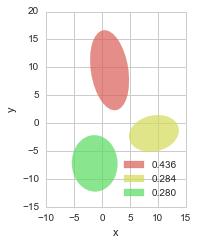

In [46]:
fig_gmm, ax = plt.subplots(figsize=(3.5,3.5))
plot_gmm_ellipses(gmm,ax=ax)
# fig_gmm.savefig('foo.pdf')

## 5.2 Goodness-of-fit statistics

In [47]:
gof_df(gmm_pdf_result, kde_result)

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.368  1.258784e-08      0.034       0.176

In [48]:
X = Y = PLOT_AXIS_RANGE
pdf_Z = generate_Z_from_X_Y(X,Y, mixed_model_pdf)# passing a function as an argument

def residule_between_kde_and_gmm(points):
    kde_vals = exp(kde.score_samples(points))
    gmm_vals = mixed_model_pdf(points)
    return kde_vals - gmm_vals 

residual_Z = generate_Z_from_X_Y(X,Y, residule_between_kde_and_gmm)

plot_3d_prob_density(X,Y,pdf_Z)
plot_3d_prob_density(X,Y,residual_Z)
align_figures()

fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,kde_Z,xlabel='x',ylabel='y')
fig_gmm = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,pdf_Z,xlabel='x',ylabel='y')
fig = plt.figure(figsize=(4,3))
plot_2d_prob_density(X,Y,residual_Z,xlabel='x',ylabel='y')
align_figures()

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAUEAAAFBCAYAAADpDh0xAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsfXvYHGV99j2zO3t8TwkBJRzDQVCaGA1YBG2xoIV61YIh
2qQkFdQKNbYVLi7F1mA/DvHCtnyXIoqCnwWkBj4E0fp5oFqxioJJkYomgIEAIQeS97SH2Z2dnfn+
2Pc3+8yzz8w8Mzu7727eua+Lize7M8/Ozs7c8zveP8W2bRsJEiRIsEChzvcBJEiQIMF8IiHBBAkS
LGgkJJggQYIFjYQEEyRIsKCRkGCCBAkWNBISTJAgwYJGQoIJEiRY0EhIMEGCBAsaCQkmSJBgQSMh
wQQJEixoJCSYIEGCBY2EBBMkSLCgkZBgggQJFjQSEkyQIMGCRkKCCRIkWNBISDBBggQLGgkJJkiQ
YEEjIcEECRIsaCQkmCBBggWNhAQTJEiwoJGQYIIECRY0EhJMkCDBgkZCggkSJFjQSEgwQYIECxoJ
CSZIkGBBIyHBBB2wbRuWZcG27fk+lAQJeo70fB9AgsGCZVkwTRO1Wg2KojivFwoFpFKpeTyyBAl6
g4QEEzjQdR2lUgm5XA6qqsK2bei6jmazCcuyoKoq0um08/+EFBMcCkhIMAFs20az2USj0UCz2US9
XndIz7IsAHCsQtM0Yds26vU6VFVFKpVKSDHBUEOxk8DPgga5v5ZloV6vo1qtCrdTFAWpVMr5T1Xb
4WS6hBJSTDCMSEhwAcM0TTSbTQBAvV5HpVIBAKRSKeTzeTSbTdRqNWGCJCHFBIcKEhJcgLBt20WA
1WoV9XrdeT+fzyOdTrtigoVCwXGb6T8WRIoUM2RJ0TAMGIaBfD6PbDabkGKCgUISE1xgsCwLjUbD
IbRyuQzLspBKpZDNZn3dYbLsgHYZDUuKpmnCNE0AbSswlUo5liGRbxJTTDBISEhwgYC14oiEiPCy
2SwKhYJDYDJg3WFanydFIlwC/Z1KpaAoii8pZjIZV4lOggS9QkKCCwCGYcA0TafspVKpoNFoQFEU
FItFZDKZrj/DjxRZy5PcaNZSDCLFVCoFTdMSUkzQEyQkeIij2WxiZmYGpmlidHQUlUoFlmUhnU5j
ZGTEFbsjxBEm5knRMAxkMhmHDC3LclmKfqTYaDRQq9XQaDSQSqVQKBQSUkwQGxISPETBu78AUCqV
ALQSH7lcTopEaBvbtrsmHYr98ccnS4qGYThJl1qtlliKCWJBQoKHINjaP3JLgRahjYyMQNO0eT7C
1rGk0+lQpEjb0f68pZiQYoIoSEjwEANlaYFWIqJSqTjEMTY25puBnU/SkCFFer1SqUi5z5RkSUgx
gR8SEjxE4Ff7R+1vw0QCIlKkYm76PqylyBduK4ri2oYSLWw9Y1KSkwBISPCQAFv7Z1kWyuUyms0m
VFXFyMgIdF13LCkZUPxvkOroicBVVRUWbvMF3KJuFlYhJ5PJOEIRRLbD9JBIEB8SEhxysNafYRiO
tUS1f4qiDMzNHSepBrnPXqTIgrUUqRg8IcWFh4QEhxSGYUDXdce1q1QqMAwDAFAsFpHNZuf5CNvo
B5n4kSI9KFhSZN1o1lJMSHHhISHBIQQJG1SrVeRyOaf2L5VKYWRkxDPWFWSJHUo3OUuK2WzWKdwm
QrRt23loAN7uc0KKhz4SEhwi8F0XAFCr1QAAuVwO+XxeeGMmNyscAlMUBc1mE5qmQVXV0DFFIkXa
PpfLIZfLORnqBMOHhASHBHztH5EfAIyMjMTS+iYCWyx9KICV+dI0zamZ5Pueg0iRyDCVSjlJJ3pP
07SEFIcICQkOAaj/FmglQsrlsnMz53K52AnQtu1DhvRkQZaiDCmyySYKQ/AlOUCbOKkcJyHFwURC
ggMMvvZP13XHAsxkMjAMI9SNFYbYBq1Ept9gSZEeCqLibcMwHIuQLdxmSZFij/x8loQUBwMJCQ4o
+Nq/SqXiKMGMjIw4gf24y06AFllSMmAhEyGBSI0lRSI/UuZhtRR51W3anwiUJUVK4PDq3An6h4QE
BxCs9ce2vmUyGRQKBaiq6tLpC0JYi4Naz/jXiAgWOtjzSUrZvKXoR4p0DinMUa/Xkc1mXcXbiaXY
PyQkOEAwTROlUgmqqjoqz9T6VigUkM1mnRsjyg0SZNWRhWLbtiOvz5IxWYfzEecaZItUZCn6qW6z
pMh+L9ZSpG0SUuw9EhIcENDFX6vVoGka6vU6ms1m17V/MrBt20W4pNlnWRZqtRpM03SRopeMfj9u
1GEgAhnVbfYcAnD+5i3FhBR7j4QE5xki3T9yRdnWt27gtz/NGaFeY5o3zO9LZR9BMvr9JsVhQFjV
bT/32TTNhBRjRkKC8wi+9k/Xdee9oNq/OC54dsxmNptFPp/H9PS07z6iG9pPB5C1YAfZpe0nvFS3
AQgtRa8HC0uK9O90Ou3EjRNSlENCgvMEtvaPnfoGtLKGvSh+Zqe+se4v9Rp7zRdm9xW9HyRkQDAM
w3HxWcmrfmJQiZhX3Q5rbVPogsIWrKVI3TEJKYqRkGCfwdf+1Wo1xwLM5XKo1Wo9q/0D3O5vULwx
CkSkWK/XnewyT4zkyrGlJP1At5/DKlzHvU7YSX48wYksxYQUvZGQYB/Bu7/lctkhh5GREaTTaVc7
nB/CXMC0baPRQLlcBuAfb4y79jCVSsE0TWQyGaRSqdClJAsdMqRIME0T1WrV133mJ/lREfdCJcWE
BPsE1vpjW980TUOxWHRqzYD4XTZaj3d/5wN+nRhEiDwp0k2aoAURKTYaDcfiCxpaxSda6vW6Y8Gz
iZaFgoQEewyq/UulUshkMq7Wt37U/pHsFtC6GUZHR6Uu8H5pAIaprwPa1nSSDW2DLWInUYiwk/wA
ODOfZ2dnYVmWc60c6qSYkGAPQX2jJOdeq9VcsvcUN+MhYwnKEACb/QXgSD51s2Yv4ef2iRR0DoVy
nLhiiyyiTPJjzyOdd3oAse7zoWgpJiTYA4h0/6iMIZPJoFgs9vSG5bO/2WzWcXmGCSwpaprmmjLn
VY7Tr8zzoGaZRQhLigRKnrGT/CjRdSiRYkKCMYNNfgBw1f7JxOLC3rj8zSjK/tLTPMyag3qTK4ri
nMOww5Z6QYqD8mAJY1HKkCLQFuwVncdDiRQTEowR5LbRRcXX/skmI6ISEF/8TNlfiqkNKrFFhdfN
zM4U4ctxepV8Gmbw55EEO/jYIkGWFPk45aAiIcEYwNf+1et1VKtVAOFd0SjbeRU/x4FhUpbmb2ZR
koXA9mbPZzlOL2KCcaBbi5vuiUql4vSiP/roozjiiCPw+te/fr6+lhAJCXYJvvavUqk4aivFYtER
QwhDImG2tSwLs7OzvsXPUWoKe4F+E6moHKdWqznWuVc5zjAmWXpJpkEPFy9SpAcLkeJjjz2G5cuX
e5Kgbdv41Kc+hR07diCTyeCGG27AMccc47z/wx/+ELfeeivS6TRWr16NNWvWeO7z7LPPYtOmTQCA
4447DjfccANUVcUNN9yAbdu2oVgsAkBrvdjP2AICX/tHU9/S6TRGRkb6Yl3QDR2X2EIvMAjHROU4
qVRrJkgul3N1sMy3Os4gwbZt32s3zCgCoHVv/OhHP4Ku68jlcp7rPvzwwzAMA1//+tfxq1/9Cps3
b8att97qrPHpT38a3/jGN5DNZrF27Vqce+652Lp1q3Cfm2++GVdddRVWrVqFa665Bj/84Q9x3nnn
4amnnsIdd9yBiYkJ53MTEoyARqOBWq3m3Chs61s+n3duMBayVpCMmjO5vwRZ91f2GKj39FBGlNY0
vowkQQtepEhGwtNPP42rr74aAPCd73wHDz30EN72trfh3e9+t+s627p1K9761rcCAF7/+tfj17/+
tfPe7373Oxx

<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAARYAAADUCAYAAABZGgxEAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJztnX9QU2f2/98hAYMkaJ0CUlChaEthsQLWbWvXcUaz2n6m
PwXWomUdabWd2p1ZkWq3W8FWxO60686U2m2H7lh1rKjdGXe67XZlSnFqbS0sxQLGVoryQwX8Ykv4
JSTk+wfekNzcX0lukpvkvGYyA7n3eXII5M15znOec1RWq9UKgiAIGQnztwEEQQQfJCwEQcgOCQtB
ELJDwkIQhOyQsBAEITsafxvgLvX19f42gSAEyc7OlnTf/777HFbLNN7rERERyMjIkMssnxCwwgIA
R3af8ngOk2kAer1OBmt8P2/L0A0AQEp6oqSxDaN9AIC5KbFO1wZMJuj0es5xF1p7AACZETMk29na
3AkAmGUZC9j31xPyti2WfK/VMg3TEl/nvf5L51aP7fE1tBQKcOQQFTGYMcwcctpFBCcB7bGEMoy3
IoYngmKPTVxc9F4uIgyB5cQTckAeSwAj1SvwVFS45pLivZDXErqQxxLENIz2iYpKg7UbAGDRWqC2
Dtmez1TF8Y6ZmxKLC609aBjtk+S5tAzdQNrUKRKtJoIB8lgCkJahG6LegJhH0WDttolKakIsZs/Q
ITUhFqkJsU7XuZDqucQnSw/4EsEDCUsQw+et2AsKIyT2sAVGbH4pyyKpMSEiOCBhCTAuSviVCX3Q
G6zdvILCRi5xoVhL6EHCEoBI+aByeStCAsEHI0JCSyM5g8NEcEDCEmTwBWztlz/uIGWcmNdCy6HQ
gYQlhOAThzZNG65GX5U0nrwWQgokLAGE2H98Po9BaAnUpmlz+Jp5CL6OgLiIBXLJawkNSFgCDLHt
Wz7PgctbYQQkLSYGyVF6pMXE2B58AiMloMsHBXFDB78JS2NjI5566ikAwLlz57BkyRIUFBSgoKAA
n376qb/MCjr4BMBeVLhgnndVXKR4LUTw45fM28rKShw/fhxRUVEAgKamJqxfvx7r1q3zhzlBgdCH
me2tiIkKQ1pMDFp6e9GmaUOyOdlpTmNXj1u2UiZu8OMXj2XOnDl4++23bd83Nzfjiy++wNq1a/Hy
yy9jaGhIYDTBhysBVDFRYd/HF3fh84j4hI6WQ6GBX4TFYDBArVbbvr/77rvx4osv4uDBg5g1axbe
eustf5gVErRp2iSLCgOfuPDtMtEOEaGIQ4jLly+H/maRIYPBgJ07d0oaZzINyPL6cs3j7XktN/8P
mEwm52saMwZYzxu1JsyeoXO43xxt5rVLyN5Z2ki0DZqcXttitqAOl5E64lgkymIx2+5lj4mdPQ3f
t/UhCeO8ryeFQPm9hSKKEJbCwkK88soryMjIwOnTp5Geni5pnByVvpReicwe9c2tWj1HpTf16JhT
BTi1dcjp3mvqa5x2SbFXMzKMa7dcc4i3pOv1MHb1OL92zzD0kXqYTCZOe3vUv0A/darg6wkRSL+3
UEQRwlJaWorXXnsN4eHhiImJwauvvupvk0IKnfYMIjUWqDVqh+cHRhY5fM8Ec6XSMNqHuQiXxUYi
sPCbsCQkJODw4cMAgLS0NHz44Yf+MiUgYEolcC2DpMIVX9FpzwAAZodPc/AsjP1XoNOecRIXZh57
ryU1IRYNXd0ONVyYmi18pKQnoqW5k3aHZMBqtaK0tBTnz59HREQEysrKMGvWLNv1zz//HHv37oVG
o8GqVauQm5vLO+bChQvYvn07gIlNlrKyMoSFheHIkSOoqqpCeHg4nn32WSxdulTQJkqQI5AaHc/7
HCM8DK4GfgnvU11djdHRURw+fBhFRUUoLy+3XTObzdi9ezf27duHAwcOoKqqCn19fbxj9uzZg6Ki
Ihw6dAjAhChdu3bNNrayshJvvvkmxsbGBG0iYSF44RIcALbMXEIZ1NfX4ze/+Q2AiR3WpqYm27XW
1lbMmTMHOp0O4eHhWLhwIc6cOcM7pqKiAtnZ2RgdHUVvby/0ej3Onj2L7OxsaDQa6HQ6JCUl4fz5
84I2kbAQgqRGxzt5LZz38RxQPK8Z5h1DJ54nuTx8kfchxsDAgMMyVqPRYHx8nPPa1KlTYTKZMDg4
yDlGpVLh8uXLePjhh/Hzzz8jNTWVdw4hFBG8JZQPO94yEch1zsi1Z25KLM7/cNkX5gU8zeb/473m
HOVyRKfTYXBw0Pb9+Pg4wsLCbNcGBia3zwcHBzFt2jTBMbfddhs+++wzHD16FOXl5VixYoXTHNHR
0YI2kccSwkjxRAD+eAuhDLKyslBbWwsA+O6773DHHXfYrqWkpODSpUvo7+/H6Ogo6urqsGDBAmRm
ZnKOee6553Dp0iUAQFRUFMLCwpCRkYH6+nqMjo7CZDLhp59+wrx58wRtIo8lxOGLo3DdZ+y/4vQ8
e4eowdrtVOFfqJo/7Q55jsFgwKlTp7B69WoAQHl5OT7++GMMDw8jNzcXL730EtavXw+r1YqcnBzE
xsZyjgGAjRs3Ytu2bYiIiEBkZCR27tyJW2+9FU899RTy8/NhtVqxefNmRERECNpEwhIgpE2dgpbm
TsTO5u/xy4Wxq8ftqnGiNrHyWrgOJibE63G1hz/OQniOSqXCjh07HJ5LTp4U+6VLlzptD3ONAYAF
CxZwpn7k5uYiNzdXsk20FApihHoDARMJcFxeCB9SA7muQkHc4IOEJYgQSkgDgGRzskuZs1Jhbz1z
7Q5RjZbQgoQlSJDaS1kO7L0WdsIc17JLymln8lqCCxIWwiWkBnuJ0IaEJUiQ0qeZIHwFCQvhFdhx
Fqm1cGk5FByQsBAuw94dYp8dcnd7m8pWBg+KqNLf3t6O/Px8rF27lnNvnSCIwMIvwlJZWYk///nP
tqPX5eXl2Lx5Mw4ePIjx8XFUV1f7wyzCB9C2c2igmCr9CxcuBAAsWbIEp0+f9odZIQM7l8WVJDlP
oOBy6KCIKv1Wq9X2dVRUlEdV0ghh2KeRuSrESUUoC1eoz7MYFMANfBRxVog5rg1IO5LNQFX67a5x
VOkHAIvW4nQ/u1J/pMYChHPPy0eCSof2sV9s88zSRuLHwR8xs3/m5GubLQDgYJd99X4uYmdPw5W2
PknvXaD83kIRRQhLWloavv32W9xzzz04efIk7r33XknjqEq/3TWOKv2AtEr9TBFtrnkF7el3/Bk1
I8MOc6j7Jw4f2tul7hnGBfWYYKawlAr+gfR7C0UUISxbt27FK6+8grGxMaSkpGDlypX+NonwEmJF
tongQBFV+pOSknDgwAF/mUIQhMxQghyhSCiAG9iQsIQA7OJLviI1IRZGres7fJSBG/iQsAQ5YsWe
CMIbkLAQsiKl3xAdSAx+FLErRMjDhdYen2a3pkbHw4jJtiCu9nYWIiU9Ea3NnbLMFQgIZT+7n8Lo
P8hjCSDSpk7BlTbu//SuVJBjl6gcGFmE9rFfPLaPcJ+BkUW8DzGsVitKSkqwevVqFBQUoKOjw+H6
559/jpycHKxevRpHjx4VHHPu3DmsWbMGBQUFePrpp9HX1+fwOs888wyqqqpEbSJhIRQNLYfEkbN3
865du7B9+3bs378fBoMB7733nm2uv/3tb5Kzs0lYCMVCu0PSkKN3c3NzM4CJpvB33nkngAlRmjJl
ot/TZ599hrCwMDzwwAOSbCJhCTIoqzX0kKN3s1qtxvj4OG699VYAwP/+9z8cOnQI69atww8//ICP
P/4Yf/jDHyTbRMHbAKS1uZPzv3lmxIyAqXcyNyUWDa09kmJDLUM3qFOiAHL3bv7kk0/w7rvv4r33
3sMtt9yCyspK9PT0oKCgAF1dXYiIiEBCQoKg90LCEmAkYRwdUIvf6AOM/Vc8KrsghVDbHXKHrKws
1NTUYOXKlYK

In [49]:
def f(V,theta):
    return (mixed_model_pdf([[V*cos(theta),V*sin(theta)]]))*V

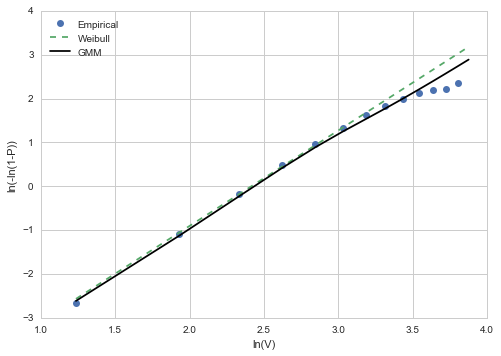

In [50]:
x = linspace(0, max_speed, 15)

# 1. Plot v-p points, empirical distribution
ecdf = sm.distributions.ECDF(df.speed)
y = ecdf(x)
plot(log(x), log(-log(1-y)),'o', label = 'Empirical')

# 2. Weibull distribution
weibull_params = sp.stats.exponweib.fit(df.speed, floc=0, f0=1)
y_cdf_weibull = sp.stats.exponweib.cdf(x, *weibull_params)
plot(log(x), log(-log(1-y_cdf_weibull)),'--', label = 'Weibull')

# 3. GMM distribution
y_ = [integrate.nquad(f, [[0, x_val],[0, 2*pi]]) for x_val in x]
y = array(zip(*y_)[0])
plot(log(x), log(-log(1-y)),'-', color='black', label = 'GMM')

plt_configure(xlabel='ln(V)',ylabel='ln(-ln(1-P))',legend={'loc':'best'})

Direction Distribution Comparison


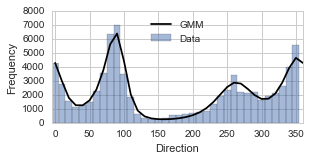

In [51]:
# Calculate Angle Distribution
x = linspace(0,2*pi, num=36+1)
y_ =[integrate.nquad(f, [[0, inf],[x_-pi/36, x_+pi/36]]) for x_ in x]

# 1. integrate.nquad returns 2 vaule, result, abserr. Need to abstract the first to plot
# 2. * length of data size, to adjust the plot space
y = array(zip(*y_)[0])*len(df['dir']) 

df['dir'].hist(bins=DIR_BIN, alpha=0.5, label='Data')
plot(x/pi*180, y,'-', color='black', label='GMM')
title='Direction Distribution Comparison'
plt_configure(xlabel='Direction',ylabel='Frequency', 
              legend={'loc': 'best'} ,tight='xtight',figsize = (4.5,2))
dir_fig = plt.gcf()
print title

Speed Distribution Comparison


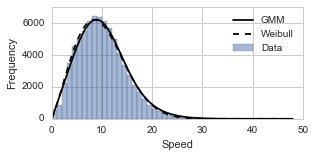

In [52]:
# Calculate Speed Distribution
# 1. GMM Model
x = arange(0, max_speed, 0.5)
y_ =[integrate.nquad(f, [[x_-0.01, x_+0.01],[0, 2*pi]]) for x_ in x]
y = array(zip(*y_)[0])*len(df.speed)/0.02
plot(x, y,'-', color='black', label='GMM')

# 2. Observation
df['speed'].hist(bins=arange(0, df.speed.max()), alpha=0.5, label='Data')

# 3. Weibull
y_weibul = sp.stats.exponweib.pdf(x, *weibull_params)* len(df.speed)
plot(x, y_weibul, '--', color='black', label='Weibull')   
title='Speed Distribution Comparison'
plt_configure(xlabel='Speed',ylabel='Frequency',legend=True, figsize=(4.5, 2))
plt.gca().set_ylim(bottom = 0)
plt.locator_params(axis='y', nbins=5)
print title

In [53]:
def direction_compare(df, angle, incre):
    angle_radian, incre_radian = radians(angle), radians(incre)  
    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
    data_size = len(sub_df.speed)    

    bins = arange(0, sub_df.speed.max()+1)

    density_, division = np.histogram(sub_df['speed'],bins=bins)
    density = density_/len(df)
    density_expected_ =[integrate.nquad(f, [[x_, x_+1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                        for x_ in bins[:-1]]
    density_expected = array(zip(*density_expected_ )[0])    
    curves = {'angle': angle, 'data_size': data_size, 'max_speed': sub_df.speed.max(),
          'density': density, 'density_expected': density_expected}
    return curves

In [54]:
%%time
incre = SECTOR_LENGTH 
density_collection=Parallel(n_jobs=-1)(delayed(direction_compare)(df, angle, incre) 
                                        for angle in arange(0, 360, incre))  

for curves in density_collection:
    angle, density, density_expected, max_speed = curves['angle'], curves['density'], curves['density_expected'], curves['max_speed'] 
    start_angle, end_angle = angle-incre/2, angle+incre/2

    title = '%s (%s - %s) Degree' % (angle, start_angle, end_angle)
    fig = plt.figure(figsize=(1.5,1.5))
    bins = arange(0, max_speed+1)
    plot(bins[1:], density)
    plot(bins[1:], density_expected)
    plt_configure(title = title)
align_figures()

/Users/cqcn1991/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAJIAAAB6CAYAAABUbAphAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAH5pJREFUeJztnXlc1VX+/5/3XrbLjrIKyOKGmoLraGaRaeXk8nMXcxwn
xtQpc8pKyZ0UHR2z35Q2Nd9qvqM2aj+zsppcUrKMChhBBWRHZJVVdu52fn9cuQpcuIBwFbzPP3x4
7+d93uf9gRfncz7nvM85EiGEwISJu0R6rwMw0TMwCclEp2ASkolOwSQkE52CSUgmOgWTkEx0CmZd
5TgyMpK33noLpVLJoEGD2L59OzY2Nh22A9izZw/jxo1jwoQJza7t3LmTkydP4ujoCICfnx9vvfXW
XdXXEikpKSxYsABfX1/dd3v37m30GaC0tJS1a9eSl5eHVColPDycESNGUFNTw+rVq9m3bx8WFhbN
/P/ud78jLy8Pe3t7hBCoVCrGjBnDq6++2u5YjYboAkpKSsT48eNFdna2EEKI3bt3iy1btnTYTggh
4uLixMqVK1usc8GCBeLixYudEpchDh8+LDZu3GjQbvXq1eL9998XQgiRlJQkJk6cKOrq6oQQQnz+
+edi586desstXrxYnDp1SvdZpVKJzZs3i+XLl7c7VmPRJY+2CxcuMHz4cLy9vQEICQnhxIkTHbYD
eOedd1iwYIHeawqFgsTERD766CNmzpzJSy+9RH5+/l3V1xoXL14kIyODefPmMX/+fE6fPt3MRq1W
ExkZybx58wAICAjA19eXH374AYCpU6dy4sQJSktL9dYh7hgnlslkhIWFERMTQ2ZmJgBnz55l/vz5
zJ49m0WLFhEXFwdAXV0da9eu5amnnmL+/PmEhYURFhYGwKRJk3j55Zd55plnOHPmDIWFhbz44ovM
mTOHmTNn8sEHHzS6x2effZbZs2czd+5cIiMjW/2ZdMmjLT8/H3d3d91nd3d3qqurqa6ubtQ0t9Wu
srKS2NhY/v73v+ut78aNG4wfP541a9bg4+PDhx9+yJ/+9CeOHz/eobgMYW1tzbRp01i4cCHp6eks
WbIET09PhgwZorMpKytDCIGTk5PuOzc3NwoKCgCwsLBg1KhRfP/998yaNctgnZaWlvj6+pKSkoJU
KmXv3r0cPHgQBwcH0tLSWLp0KWfOnGHfvn2o1WpOnjxJVVUVzz77bKO4Bg4cyN69ewH4/e9/zx/+
8AeCg4NRKBQsW7aMvn378vDDDxMWFsZHH31Enz59uHHjBvPnz+fw4cONfn53YlBIQgi2bNlCcnIy
FhYWbN++XfcXDdq/jP3792NmZsacOXOYN28eGo2G6OhoFi5ciIWFBeHh4QCkpqby0ksv6foSzs7O
2NvbN6tTJpM1+nzt2jVcXV0xM9MfrpeXF++//77uc2hoKPv37yc3NxdPT89G96KPpvUZYtOmTbr/
9+vXj6lTp3L27NlGvzCNRqO3rFR6+yHQt29fXQvTFiQSCVZWVly4cIHi4mKWLl2quyczMzOysrI4
f/68rgWytbVl1qxZJCcn63yMHj0agNraWqKjo6moqODtt9/WfZeUlIRcLqeoqIgXXnhB518qlZKc
nNxxIZ05cwaFQsHhw4eJj49nx44d7N+/HwCVSsXOnTv57LPPsLS0JCQkhCeeeILS0lKqq6v5+uuv
iY+PZ+vWrdjb25Oamspzzz3H0qVLAfjyyy/59ttvdXUVFBRgb2+PlZVVoxikUilqtVr3+W9/+xtn
z55FIpEwadIknnzySa5evcrMmTN1NkKIZsLz8PAgPj7eYH1N/a9atUp3TaPR8MEHH7BkyRKsra1b
rKt3796AtjW1s7MDoLCwsNEvQq1W6+1s66O2tpaMjAwGDhzI9evXGT9+fKOXiYKCAlxdXZHJZI3+
YO4ULqCLueHneeTIEV0MZWVlWFlZ8fPPP9O/f3+OHDmiK3fjxg3dPenDYB8pNjaWiRMnAhAYGMiV
K1d019LT0/Hx8cHW1hZzc3NGjx7Nr7/+ikKhoKqqiuzsbAIDA4mPj+eJJ54gISGByMhIFi9ezPr1
6xk5ciSXLl0iOztbd1NPPPFEsxi8vb0pKSlBoVAA8NJLL/H5559z/PhxVq1ahVQqJSIigtzcXAAO
HTpEQEAAbm5ujfw88sgjbaqvqf9GPzCplLNnz3L06FEAcnNzOXXqFE8++WQjO5lMxmOPPcbhw4cB
uHr1KhkZGYwdO1Znk5OTg7+/v6FfAXV1dezYsYPHHnsMDw8Pxo0bx4ULF8jIyADg+++/Z+bMmSgU
CoKDg/nss88QQlBbW8tXX32FRCJp5tPW1pbAwEA+/PBDACoqKggJCeG7774jMDCQrKwsYmJiAEhK
SuKpp57ixo0bLcZosEWqqqrS/UWBtgnVaDRIpdJm16ytramsrEStVhMaGsqqVatQqVSo1Wpef/11
zp07x6hRo/joo4/w9vbm0KFDRERE6Oy8vb3ZtWtXsxjs7OwYPXo0v/zyi07UdzJgwAA2bNjAihUr
0Gg0uLu76/5ar1y5wsaNGzl+/Di9evVqU32G2LNnD5s2beLYsWMIIVi/fr1OEM8//zwhISE8/vjj
bN68mfXr1/Pll18ikUjYvXs3tra2gPYFIS4ujoiICL117Nq1i/feew+JRIJarebhhx9mw4YNAPTv
35/w8HBeeeUVQCva9957DysrK5YvX054eDgzZszA1taW3r17I5fLAZoJas+ePYSHhzN9+nRUKhXT
p09n2rRpgPblZteuXdTX1yOEYPfu3Xh4eLT4M5GIljoOt9i5cydBQUE8/fTTAAQHB+t68MnJyezZ
s0fX29+xYwejRo3i4sWLBAYGNitzZzOfnp7Otm3b+Pjjj1usOzY2Vvf/lJQUvvjiC1577bXWwu02
nD9/ntzcXEJCQjrVb1RUFHK5nKCgIIQQvP322wwfPlzX8o4aNapT62vAYIs0cuRIzp07x9NPP01c
XBwDBw7UXevXrx/Xrl2joqICKysrYmJiCA0NBdBbJjQ0lI0bNzJs2DCioqIYOnSowQAbbnzUqFFk
Z2dTW1vLI4880swuNja2TT+kmJgYPiv7jrTSLCb3m8ilgkRKasrYO3Uz7nauHfLZVrsG24CAAPbv
38++ffua9c866rPB1t7enk2bNnHixAmUSiXjxo1jzZo1yGSyRn+YnY1BIU2ZMoULFy6wcOFCQNvq
fPXVV9TW1jJv3jzCwsJ47rnnEEIwd+5cXF1d9ZYB2Lp1K+Hh4Zibm+Pi4qJ7m2sra9eube/9NeNa
bR5ppVmM9Qri+dGLiLoey96f/odPLn/BKw8vu2v/bcHGxkbXN+lsBgwYwL///e8u8d0aBoUkkUjY
unVro+/8/Px0/w8ODiY4ONhgGYDBgwffk5u8k5/LtG9tswZrH7vjvEbSv5cvP1//L6klmQzo7dda
cRMt8EBN2qYUZ3CtNo9A98H06+UDaEW/aLh22OBM+o/3MrxuzQMlpMisnwGYEdD4VX2Iy0DsLGy4
VJjU4qClidZ5YIQkhOBi/hWspJYMdRnY6JpUKmWYWwAlNWXkVRbeowi7Nw+MkHIq8impKcPP2rPZ
aC/AcPfBAMQXJBo7tB7BAyOki/naEXl/a2+914e7aYV0qfCq0WLqSTxAQkoAwM/aU+91Z5teeNq5
k3AjBZVaZczQegQPhJBqlLVcLU6nn5MPNmbWLdoNdx9MvaqelJIMI0bXM3gghHSlMBm1Rk2QR+sj
6bf7SUnGCKtH8UAIqaEDPcKAkAa79AcwtUgdwKCQhBBs3ryZhQsXsmTJEq5fv97o+tmzZ5k7dy4L
Fy7k008/bVOZEydO6KZPjMHVojQsZRb43xqEbAlrczkedq5kll03jSe1E4NCujOxbc2aNbp5M7id
2PbPf/6TAwc

CPU times: user 7.9 s, sys: 344 ms, total: 8.25 s
Wall time: 15.9 s


In [55]:
# This R square is compute as in paper 
# Comparison of bivariate distribution constructionapproaches for analysing wind speed anddirection data
# http://onlinelibrary.wiley.com/doi/10.1002/we.400/full
true_R_square(density_collection)

0.8980859151139845

## 5.3 Sectoral Comaprison

In [56]:
# Calculate Speed Distribution
def model_data_comparison(df, original_incre = 10, incre = 10):
    start, end = -original_incre/2 + incre/2, 360
    max_diff_array = []
    curve_collection = []
    max_speed = df.speed.max()
    
    # Find a max count for plotting histogram
    max_count = max_count_for_angles(df, start, end, incre)
    plot_range = [0, max_speed, 0, max_count*1.05]
    
    for angle in arange(start, end, incre):
        angle_radian, incre_radian = radians(angle), radians(incre)  
        start_angle, end_angle = angle-incre/2, angle+incre/2
        
        # Select data from observation
        sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
        data_size = len(sub_df.speed)
        direction_prob = integrate.nquad(f, [[0, inf],
                                             [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
        weibull_params = sp.stats.exponweib.fit(sub_df.speed, floc=0, f0=1)
        
        fig = plt.figure(figsize=(13,1.3))
        x = linspace(0, sub_max_speed, 20)
        # 1. Frequency Comparison
        ax1 = fig.add_subplot(1,3,1)        
        # 1.1. Data Histogram
        sub_df['speed'].hist(bins=arange(0, sub_max_speed), alpha=0.5, label='Data')             
        # 1.2. Model Distribution
        y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], 
                                     [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                                 for x_ in x]
        y_gmm = array(zip(*y_gmm_)[0])/direction_prob[0]/0.02
        plot(x, y_gmm*data_size,'-', color='black', label='GMM')
        # 1.3 Weibull Distribution
        y_weibull = sp.stats.exponweib.pdf(x, *weibull_params)
        plot(x, y_weibull*data_size, '--', color='black',label='Weibull')   
        plt_configure(xlabel = "V", ylabel='Frequency', legend=True)
        plt.axis(plot_range)
        
        # 2. CDF Comaprison
        ax2 = fig.add_subplot(1,3,2)
        # 2.1. Empirical distribution
        ecdf = sm.distributions.ECDF(sub_df.speed)
        y_ecdf = ecdf(x)
        # 2.2. Model
        y_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
             for x_val in x]
        y_cdf_gmm = array(zip(*y_)[0])/direction_prob[0]
        # 2.3 Weibull
        y_cdf_weibull = sp.stats.exponweib.cdf(x, *weibull_params)
        
        plot(x, y_ecdf,'o', alpha=0.8, label='Data')
        plot(x, y_cdf_gmm,'-', color='black',label='GMM')
        plot(x, y_cdf_weibull,'--', color='black',label='Weibull')
        plt.gca().set_xlim(right = max_speed)
        plt_configure(xlabel = "V", ylabel='P', legend=True)
        
        # 3. Weibull Comparison
        ax3 = fig.add_subplot(1,3,3)
        plot(log(x), log(-log(1-y_ecdf)),'o', alpha=0.8, label='Data')
        plot(log(x), log(-log(1-y_cdf_gmm)),'-', color='black', label='GMM')
        plot(log(x), log(-log(1-y_cdf_weibull)),'--',color='black',label='Weibull')
        plt_configure(xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
        plt.gca().set_xlim(right = log(max_speed+1))
        
        title = '%s (%s - %s) degree' % (angle, start_angle, end_angle)
        print title      

        bins = arange(0, sub_df.speed.max()+1)
        density, _ = np.histogram(sub_df['speed'],bins=bins, normed=True)
        density_expected_ =[integrate.nquad(f, [[x_, x_+1],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
                    for x_ in bins[:-1]]
        density_expected_gmm = array(zip(*density_expected_ )[0])/direction_prob[0]
        R_square_gmm = sector_r_square(density, density_expected_gmm)
        
        density_expected_weibull = sp.stats.exponweib.cdf(bins[1:], *weibull_params) - sp.stats.exponweib.cdf(bins[:-1], *weibull_params) 
        R_square_weibull = sector_r_square(density, density_expected_weibull)

        diff, diff_weibull= np.abs(y_ecdf - y_cdf_gmm), np.abs(y_ecdf - y_cdf_weibull)
        max_diff_array.append([len(sub_df), angle, diff.max(), x[diff.argmax()], 
                               diff_weibull.max(), x[diff_weibull.argmax()], R_square_gmm, R_square_weibull])
        curves = {'angle': angle, 'data_size': data_size, 'weight': direction_prob[0], 
                  'x': x, 'gmm_pdf': y_gmm, 'gmm_cdf': y_cdf_gmm,
                  'weibull_pdf': y_weibull, 'weibull_cdf': y_cdf_weibull, 'ecdf': y_ecdf}
        curve_collection.append(curves)
        
        plt.show()
        print 'data size:', len(sub_df), 'weight', len(sub_df)/len(df)
        print 'GMM', 'Weibull'
        print 'R square', R_square_gmm,  R_square_weibull
        print 'max diff:', diff.max(), diff_weibull.max(), 'speed value:', x[diff.argmax()], 'y gmm', y_cdf_gmm[diff.argmax()]
        print ' '
    return max_diff_array, curve_collection

5.0 (-5.0 - 15.0) degree


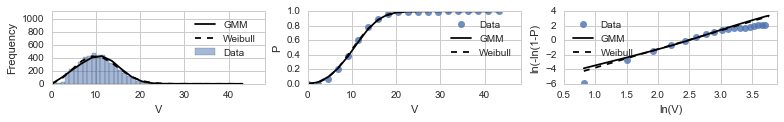

data size: 4945 weight 0.064663345233
GMM Weibull
R square 0.974022865266 0.987940830959
max diff: 0.0274966372533 0.0206251012532 speed value: 11.3497574885 y gmm 0.570683342524
 
25.0 (15.0 - 35.0) degree


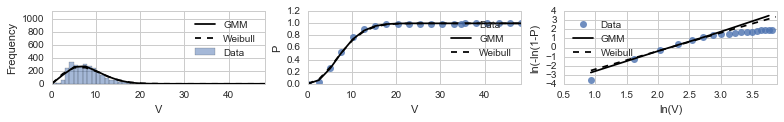

data size: 2688 weight 0.0351496606645
GMM Weibull
R square 0.942962880436 0.918724692555
max diff: 0.0351025219261 0.0487903684648 speed value: 10.1537361931 y gmm 0.735358787598
 
45.0 (35.0 - 55.0) degree


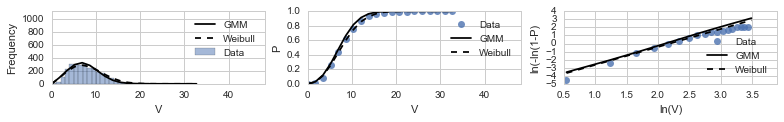

data size: 2770 weight 0.036221934539
GMM Weibull
R square 0.964775641605 0.967389928313
max diff: 0.0557777894926 0.0296006463655 speed value: 10.333918275 y gmm 0.815705587327
 
65.0 (55.0 - 75.0) degree


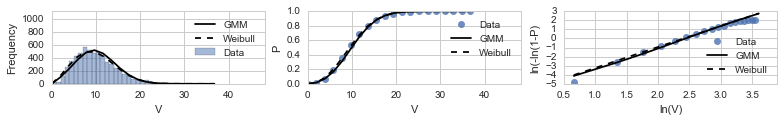

data size: 5844 weight 0.0764191283198
GMM Weibull
R square 0.959039622738 0.98387027921
max diff: 0.0561231673654 0.0167699095155 speed value: 9.67720024549 y gmm 0.477073273429
 
85.0 (75.0 - 95.0) degree


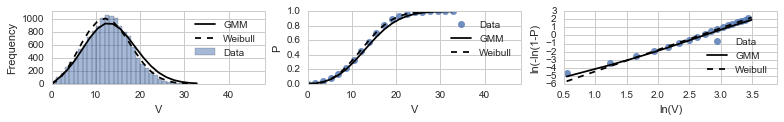

data size: 13421 weight 0.17549984962
GMM Weibull
R square 0.966910040409 0.980403946294
max diff: 0.0654484380612 0.0235983887376 speed value: 17.266607022 y gmm 0.74738220049
 
105.0 (95.0 - 115.0) degree


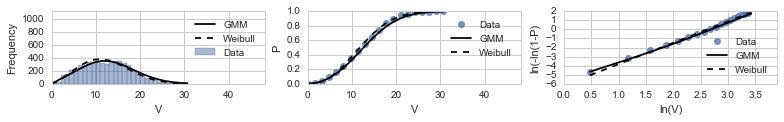

data size: 5413 weight 0.0707831522237
GMM Weibull
R square 0.950554554096 0.939073490849
max diff: 0.0453196375858 0.0347192820729 speed value: 17.7608846901 y gmm 0.790630851976
 
125.0 (115.0 - 135.0) degree


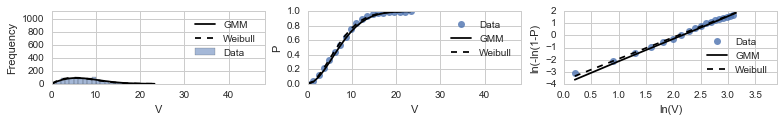

data size: 949 weight 0.01240960862
GMM Weibull
R square 0.897894156927 0.894911120805
max diff: 0.0481442743123 0.0356438235724 speed value: 11.0103462828 y gmm 0.792740867943
 
145.0 (135.0 - 155.0) degree


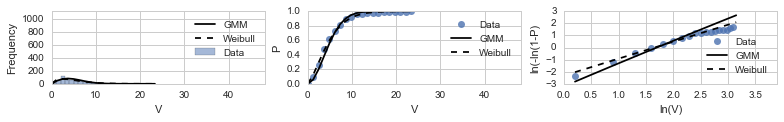

data size: 543 weight 0.00710054529049
GMM Weibull
R square 0.827418636085 0.86525552284
max diff: 0.104403596391 0.0284773876944 speed value: 3.68392862752 y gmm 0.379942628287
 
165.0 (155.0 - 175.0) degree


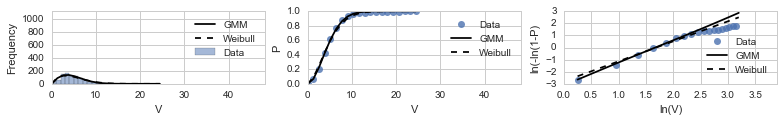

data size: 893 weight 0.0116773240229
GMM Weibull
R square 0.949640105643 0.914108167986
max diff: 0.0274382880066 0.0507795830147 speed value: 2.57427191771 y gmm 0.230125857995
 
185.0 (175.0 - 195.0) degree


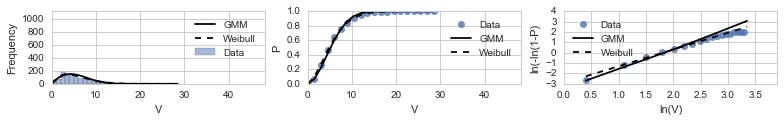

data size: 1163 weight 0.0152079819021
GMM Weibull
R square 0.911455908833 0.930960220036
max diff: 0.0545284464436 0.0306370733035 speed value: 4.49306044607 y gmm 0.413227357512
 
205.0 (195.0 - 215.0) degree


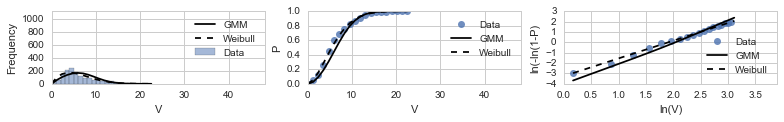

data size: 1477 weight 0.0193140062506
GMM Weibull
R square 0.735814102017 0.878814688005
max diff: 0.16107001107 0.0502865247664 speed value: 5.92608048012 y gmm 0.441502771597
 
225.0 (215.0 - 235.0) degree


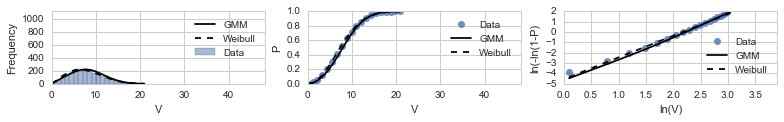

data size: 2174 weight 0.0284283341833
GMM Weibull
R square 0.951680478877 0.96707406842
max diff: 0.0488793473393 0.018398519353 speed value: 7.71563170018 y gmm 0.4759596591
 
245.0 (235.0 - 255.0) degree


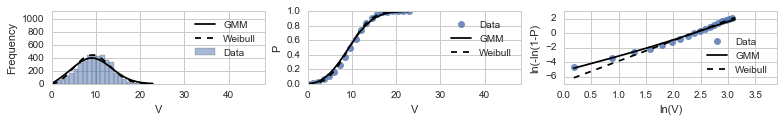

data size: 4269 weight 0.0558236240242
GMM Weibull
R square 0.921817466381 0.949938131377
max diff: 0.0433803382919 0.0325449700616 speed value: 8.41581557068 y gmm 0.41489591571
 
265.0 (255.0 - 275.0) degree


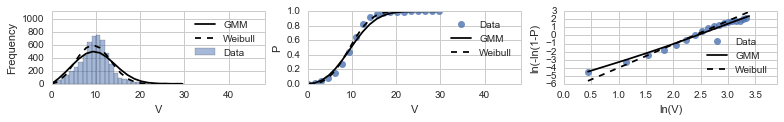

data size: 5618 weight 0.0734638369098
GMM Weibull
R square 0.834253683008 0.917621533129
max diff: 0.10045666259 0.0544931447037 speed value: 14.0102511584 y gmm 0.819621657097
 
285.0 (275.0 - 295.0) degree


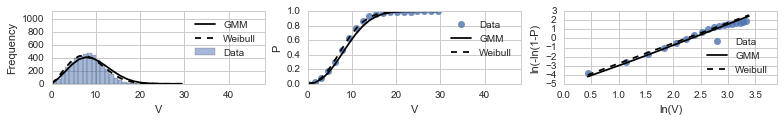

data size: 4386 weight 0.0573535757718
GMM Weibull
R square 0.954061405393 0.98180490187
max diff: 0.0859916088507 0.0234343272364 speed value: 10.8431029965 y gmm 0.684870224255
 
305.0 (295.0 - 315.0) degree


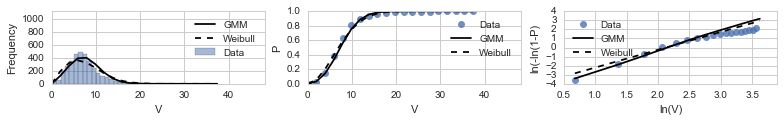

data size: 3566 weight 0.0466308370274
GMM Weibull
R square 0.942227203692 0.916979781417
max diff: 0.0797187495468 0.0591980346779 speed value: 7.87412222419 y gmm 0.556007554435
 
325.0 (315.0 - 335.0) degree


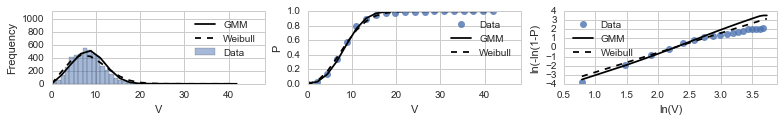

data size: 4726 weight 0.0617995893976
GMM Weibull
R square 0.974254807037 0.956376054217
max diff: 0.0363931861347 0.0518628625851 speed value: 8.80499283539 y gmm 0.544436267949
 
345.0 (335.0 - 355.0) degree


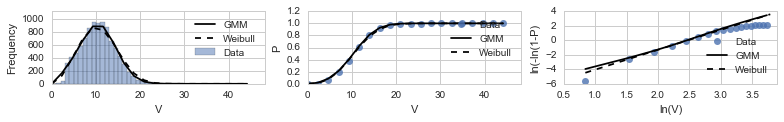

data size: 9554 weight 0.124932982883
GMM Weibull
R square 0.989562519974 0.983444441917
max diff: 0.0220391513613 0.0232616617528 speed value: 6.97461860882 y gmm 0.212744615041
 
CPU times: user 49 s, sys: 390 ms, total: 49.3 s
Wall time: 49.3 s


In [57]:
%%time
if len(effective_column) == 16:
    rebinned_angle = 22.5
else: 
    rebinned_angle = 20
max_diff_array, curve_collection = model_data_comparison(df, SECTOR_LENGTH, rebinned_angle)

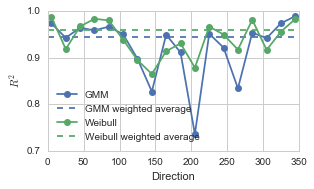

In [58]:
diff_df = pd.DataFrame(max_diff_array,columns=['datasize','direction', 'gmm', 'speed_gmm',
                                               'weibull', 'speed_weibull', 'r_square_gmm', 'r_square_weibull'])  

plot_sectoral_comparison(diff_df.r_square_gmm, diff_df.r_square_weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="$\ R^2$")

(0.0, 0.20000000000000001)

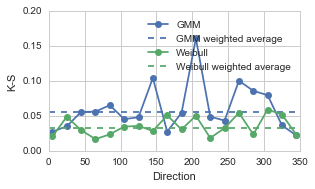

In [59]:
plot_sectoral_comparison(diff_df.gmm, diff_df.weibull, diff_df.direction, diff_df.datasize)
plt_configure(ylabel="K-S")
ylim = max(plt.gca().get_ylim()[1],0.15)
plt.gca().set_ylim(top=ylim)

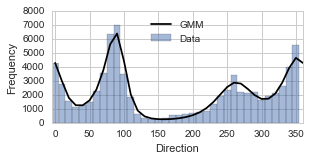

In [60]:
# Compare direction weight with previous figure
display(dir_fig)

### 5.3.1 Data Variability, by Bootstrap (Resampling)

In [61]:
max_diff_element = max(max_diff_array, key=lambda x: x[2])
angle =  max_diff_angle = max_diff_element[1]
incre = rebinned_angle

In [62]:
FRACTION = 1

# Select data from observation
start_angle, end_angle = angle-incre/2, angle+incre/2
angle_radian, incre_radian = radians(angle), radians(incre)  
sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)
weibull_params = sp.stats.exponweib.fit(sub_df.speed, floc=0, f0=1)

205.0 (195.0 - 215.0) Degree Speed Distribution
0.157296097139 5.0 0.337626042333


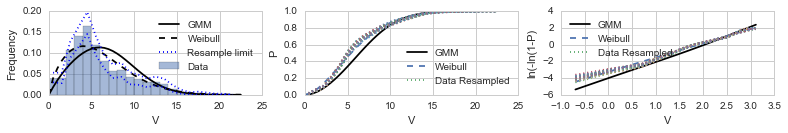

In [63]:
fig = plt.figure(figsize=(13,1.5))
ax1 = fig.add_subplot(1,3,1)   
ax2 = fig.add_subplot(1,3,2)   
ax3 = fig.add_subplot(1,3,3)   

x = arange(0, sub_max_speed, 0.5)

# 1. Data
bins=arange(0, sub_max_speed)
sub_df['speed'].hist(ax=ax1, bins=bins, alpha=0.5, label='Data', normed=True)  

# 2. GMM
y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_ in x]
direction_prob = integrate.nquad(f, [[0, inf], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm = array(zip(*y_gmm_)[0])/direction_prob[0]/0.02  
y_gmm_cdf_ =[integrate.nquad(f, [[0, x_val],[angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
y_gmm_cdf = array(zip(*y_gmm_cdf_)[0])/direction_prob[0]
ax1.plot(x, y_gmm,'-', color='black', label='GMM')
ax2.plot(x, y_gmm_cdf,'-', color = 'black', label='GMM')
ax3.plot(log(x), log(-log(1-y_gmm_cdf)),'-', color = 'black',label='GMM')

# 3. Weilbull 
y_weibull = sp.stats.exponweib.pdf(x, *weibull_params)
y_weibull_cdf = sp.stats.exponweib.cdf(x, *weibull_params)
ax1.plot(x, y_weibull,'--',color='black',label='Weibull')
ax2.plot(x, y_weibull_cdf,'--',label='Weibull')
ax3.plot(log(x), log(-log(1-y_weibull_cdf)),'--',label='Weibull')

# 4. Data Resampled
count_collection = []
for i in xrange(1,100):
    sub_df_resampled = sub_df.sample(frac=FRACTION, replace=True)    
    resampled_count, _ = np.histogram(sub_df_resampled['speed'], bins=bins, normed=True) 
    count_collection.append(resampled_count)
    
    ecdf = sm.distributions.ECDF(sub_df_resampled.speed)
    y_ecdf = ecdf(x) 
    ax2.plot(x, y_ecdf,':', label='Data Resampled')
    ax3.plot(log(x), log(-log(1-y_ecdf)),':', label='Data Resampled')
    if i == 1: 
        plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
        plt_configure(ax=ax3, xlabel='V',ylabel='ln(-ln(1-P)',legend={'loc':'best'})

print '%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle)
count_collection = np.array(count_collection)
mx, mn = np.max(count_collection,0), np.min(count_collection,0)
ax1.plot(bins[1:]-0.5, mx, ':', color='blue')
ax1.plot(bins[1:]-0.5, mn, ':', color='blue', label='Resample limit')
ax1.set_ylim(bottom = 0)
plt_configure(ax=ax1, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.locator_params(axis='y', nbins=5)
ax2.locator_params(axis='y', nbins=5)
ax3.locator_params(axis='y', nbins=5)

diff = abs(y_ecdf - y_gmm_cdf)
print diff.max(), x[diff.argmax()], y_gmm_cdf[diff.argmax()]

### 5.3.2 Time Variability

In [64]:
fig_time_variability_3d = plt.figure()
ax1 = fig_time_variability_3d.gca(projection='3d')

fig_time_variability_cdf,ax2 = plt.subplots(figsize=(3,1.8))
fig_time_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))
 
x = arange(0, sub_max_speed, 0.5)

# 1. GMM
direction_prob = integrate.nquad(f, [[0, inf], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]])
y_gmm_ =[integrate.nquad(f, [[x_-0.01, x_+0.01], [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) 
          for x_ in x]
y_gmm = array(zip(*y_gmm_)[0])/direction_prob[0]/0.02
y_gmm_cdf_ =[integrate.nquad(f, [[0, x_val],
                         [angle_radian-incre_radian/2, angle_radian+incre_radian/2]]) for x_val in x]
y_gmm_cdf = array(zip(*y_gmm_cdf_)[0])/direction_prob[0]

ax2.plot(x, y_gmm_cdf,'-', color='black', label = 'GMM')
ax3.plot(log(x), log(-log(1-y_gmm_cdf)),'-', color='black',label='GMM')

# 2. Weibull
y_weibull = sp.stats.exponweib.pdf(x, *weibull_params)
y_weibull_cdf = sp.stats.exponweib.cdf(x, *weibull_params)
ax2.plot(x, y_weibull_cdf,'--', label='Weibull')
ax3.plot(log(x), log(-log(1-y_weibull_cdf)), '--', label='Weibull')

# 3. Data
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])
for start_time in xrange(20000000, 20150000, 50000):
    end_time = start_time + 50000 
    time_label = start_time//10000
    df_other_years = df_all_years.query('(date >= @start_time) & (date < @end_time)')
    df_other_years_at_angle, sub_max_speed_other_year = select_df_by_angle(df_other_years, start_angle, end_angle)
    if len(df_other_years_at_angle) > 0 :
        
        ecdf = sm.distributions.ECDF(df_other_years_at_angle.speed)
        y_ecdf = ecdf(x)
        ax2.plot(x, y_ecdf,':', label = time_label)
        ax3.plot(log(x), log(-log(1-y_ecdf)),':', label = time_label)
        
        title = '%s - %s' %(time_label, time_label+4)
        count, division = np.histogram(df_other_years_at_angle['speed'], normed=True,
                                       bins=arange(0, sub_max_speed_other_year))
        ax1.bar(left=division[:-1], height=count, zs=time_label, zdir='x', 
                color=next(prop_cycle), alpha=0.8)
        x_3d = time_label*np.ones_like(x)
        ax1.plot(x_3d, x, y_gmm, '-', color='black', label='GMM'  if time_label == 2010 else '')
        ax1.plot(x_3d, x, y_weibull, '--', color='blue', label='Weibull' if time_label == 2010 else '')
        
print '%s (%s - %s) Degree Speed Distribution' % (angle, start_angle, end_angle)
ax1.set_ylim(bottom = 0)
ax1.set_zlabel('Frequency')
plt_configure(ax=ax1, xlabel='Time',ylabel='V', legend=True)
plt_configure(ax=ax2, xlabel='V',ylabel='P',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel="ln(V)", ylabel="ln(-ln(1-P)",legend={'loc':'best'})
ax1.set_zlim(bottom = 0)
align_figures()

205.0 (195.0 - 215.0) Degree Speed Distribution


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAFBCAYAAAD69Z+AAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsnXmYFNW5/7+19j4zjOyyCAgiLiDIxY0bNXqvmnivUbmi
RvRKEgkuEQ33d92umAiYuG8I7uJG3BeEmCDiFkMABUUEI7LINrLO9F7r74+eU1Nd0z29VfVUTZ/P
8/jIzHSdPl1ddb71vuc938Pouq6DQqFQKBRKh7Cd3QEKhUKhULwAFUwKhUKhUIqACiaFQqFQKEVA
BZNCoVAolCKggkmhUCgUShFQwaRQKBQKpQioYFIoFAqFUgRUMCkUCoVCKQIqmBQKhUKhFAEVTAqF
QqFQioAKJoVCoVAoRUAFk0KhUCiUIqCCSaFQKBRKEVDBpFAoFAqlCKhgUigUCoVSBFQwKRQKhVI1
vv/+e1xzzTWYOHEiLr30UkyZMgXffvstHnzwQYwYMQK7d+82Xrtv3z4ceeSReOONN7B9+3YMHz4c
jz32WFZ7U6ZMwaRJk6rSdyqYFAqFQqkKqVQKU6dOxS9+8QssWLAAzzzzDK688kr87ne/A8MwGDRo
EBYvXmy8/p133kHfvn2NnwcMGIC//OUvxs8HDhzA1q1bq9Z/vmrvRKFQKBTXMH36dLz88su2tjlh
wgTceeedef++dOlSHHfccTj66KON3x111FGYP38+HnroIZx55plYvHixETEuW7YMp5xyivHabt26
oVu3bvjuu+8wePBgLF68GGeeeSZWrFhh6+fIB40wKRQKhVIVtm3bhoEDBxo/T506FZdccgnOOOMM
NDU1oXv37ggGg9i2bRu2bt2KPn36wOfzZbXxk5/8BO+88w4A4L333sNpp51Wtf7TCJNCoVBqkDvv
vLPDaNAJ+vTpg7Vr1xo/z5kzBwBwwQUXQFEUMAxjCKIsyzj77LPx8ccfG69nGAannXYaLrroIpx7
7rno0aNHO0F1EhphUigUCqUq/PjHP8ann36KL774wvjdli1bsGvXLjAMAwD4t3/7N7z33nv47LPP
MG7cuHZtBAIBDBo0CHfeeSfOPvtsAICu61XpP40wKRQKhVIVgsEg5s6di7vuugu7d++GoijgeR43
3ngj/vnPfwIAwuEwevfunZW6tXL22Wfj1ltvxb333otNmzYZYus0jF4taaZQKBQKxcPQlCyFQqFQ
KEVABZNCoVAolCKggkmpWXRdh6IoVSsYoFAo3oYW/VBqDl3XoaoqZFlGOp0Gx3FgWRaapkHXdfj9
fgiCULVCAgqF4g2oYFJqBl3XkUwmEYvF4Pf7IYoiWDaTZNE0DclkEqqqQtd1pFIpMAwDlmWN/ziO
A8dxVEgplBqFCialy0MiSkVRoCiK8W9JkqAoihFhmlOzRBQ1TTMiT/J7IqTk/zzPGz9TKJSuC53D
pHRZyBxlOp02XEQ0TQMApNNpyLJsvEaSJONviUQCiUQCqVTKEFWzmJoFOJ1OIx6PIxqNIhaLIZFI
IJlMQpIkI1qlUCgZLrvsMnz55ZcAAFmWceyxx+LJJ580/n7JJZdg/fr17Y776KOP8PLLL2P79u24
4IILin6/k046yWh306ZNFfaeRpiULohZ0IBMVKgoCpLJJGRZBgCwLItgMGiIpKZphmgSYSV/M0Oi
UfN/JLIk7wvAEGPr60hal6SCKZRa4sQTT8SqVatw1FFHYeXKlRg/fjw++OADXH755ZAkCTt37sTw
4cPbHTd+/HgAwPbt2zs1k0PvWkqXIVdEqaoqotEoWlpaIMsyOI4DAPh8PgiCYIgZSasCGeutUCiE
YDBovI7MXZqLhZLJJOLxOOLxOJLJpBG1EtE0z48qigJZlo051Gg0ahyXSqVotS6lUzjkkNz/2fV6
KyeccAJWrlwJAPjwww8xYcIEIzvz+eefY+zYsVixYgUuuugiXHLJJbjpppugKApef/113H333QCA
vXv3YurUqbjgggvwyCOPAABuuOEGw3P2o48+wg033FB8p0qARpgUz0MiO5ICzRVR8jyPQCAAXdcR
i8UKtmmeq7S+F4k+zf+R97e2YY1ISbsAsqJYSZKyjiHvTQuNKF2JESNG4LvvvgMArFixAtdddx2O
P/54/O1vf8OGDRtw0kkn4eabb8aLL76IxsZG3H///Xj99dfB87xxDySTSdx5550IBAK4+OKLs7b/
choqmBTPkksoVVXNKZTkhiO/LxdzWtXaFyKcZiElaWEz1pSuVUiJ8FoLjcjfBEGAz+ejhUaUitm8
2dnXW2EYBsOHD8eHH36IHj16QBAEjB8/HsuWLcOGDRtw8cUX45ZbbsG1114LXdchSRJOOOEEDBgw
wGjjsMMOQygUApDZS3OzpVNOZmqoYFI8RzlCmasNO8klpLqu541Iy5kfVRQFqVQKoihCluWsKNRc
sWsWWArFbRx//PGYN28efvrTnwIAxowZg4cffhgsy6Jbt27o06cP5syZg3A4jKVLlyIUCmHHjh3G
8Rs3bkQymYQgCPjiiy9wwQUX4NNPP8Xu3bsBAOvWrXOs71QwKZ7BDqHsCLM42UFHaV3yWYpJ6xLx
NB9PfiZCau63+RiGYcDzPE3rUlzDiSeeiP/7v/8z9uIUBAH19fU4/PDDwTAMbrzxRvzqV7+CpmmI
RCL4wx/+kCWYDQ0NmDZtGvbt24ezzjoLQ4YMwYQJE3DjjTfi7bffxiE5JlXtuvbpbiUU11PMHCXH
cQgGgwWFUlEUtLS0wO/3IxgMGnOHQNtSk0Ag0C7lWg3yRaO5btFC86PWdskx1IiBQikfGmFSXAsp
0JEkyRAxa0TJcRwCgUCXsLIrND8qy7JR/WuOLM0Umh+lRgwUSvlQwaS4DnNEKUkSJEmCKIqGIQBQ
uVB6KbFChJSIpCAIEAShpPlRElEWWj+q6zrS6bRxjDUipUJKqWWoYFJcQ67UKxE2shSkK0WUlVDq
/GguIbWmaPMJqdmxyDo/ynFcWfPFFIoXoYJJ6XRyCSUxQ7c681QqlF19YO/M9aPkdbqug+d5iKLY
5c83pbaggknpNDoSSvNArOs6gsEgRFG09b3N7ef6W1eiGutHSTuk5J/sBmOeH6WFRhQvQwWTUnWK
EUqSeiU2dNUYYGtxELdj/ah5ftO644t1ftR8TC5/3Vr8DijegQompWqUIpQk9WpNF1YKHZALY8f8
qCzL0DStJKN6cyqYGtVT3AgVTIrjlCOUudqgdC7FzI+S/UYBlDQ/ajaqzzc/So0YKJ0NFUyKY9gh
lE4NilSA7cMcDZKsgCiKEATB1vlRalRP6WyoYFJsp1ih9Pv9tJKyC2P3/Kg1rQvkN6qnRgwUJ6CC
SbENYjQAtA1cmqYhlUplLYYPBAIlC6Wd/q6UzqPQ/GiuiLTc9aPk3+ZrzxqRUiGllAIVTErFkAEq
kUggHo8b6yXtEMpqpmTtNl+nFI9ZSHm+bViyc/2o2U6QOEiRLAc1YqAUAxVMStnkSr0CmcEokUgA
KF8oc70Xxf2YU6N24NT6UfP1VKjQiM6PUghUMCklk2+OMpVKAcjsCGKXUNIBipILO+ZHgbYlLbnm
R6lRPcUKFUxK0XQklCT1CmT2twuHw7YOInQOk1KIUuZH8y19qWR+lBrVd32oYFIKks8UPZFIZA0Y
oigilUp5InVFU7y1Q675UbL3qc/nAwBb5kepUX3XhwomJS/FCiVJvaqqaqRl7cLpwSWXlyyl60O+
cxINWv/m9PpROj/qTahgUtpRqlBab3QnBMjONvMNTLRKtvbIZ5bh9PpR6/woOYYa1bsbKpgUg2KF
0u/3w+fztbuRnbix6WDhLeyuknULnbF+lCBJkvGASo3qOxcqmJSKhTJXe0700Yn2aDRZm9hZROb0
+lFZlsGyLAR

### 5.3.3 Adjacent Sector Variability

In [65]:
incre = rebinned_angle
angle_group = [max_diff_angle-incre, max_diff_angle, max_diff_angle+incre]

In [66]:
fig_adjecent_variability_3d = plt.figure()
ax1 = fig_adjecent_variability_3d.gca(projection='3d')
fig_adjecent_variability_cdf, ax2 = plt.subplots(figsize=(3,1.8))
fig_adjecent_variability_weibull, ax3 = plt.subplots(figsize=(3,1.8))

legend_3d = False
prop_cycle=iter(mpl.rcParams['axes.color_cycle'])

curve_df = pd.DataFrame(curve_collection)

for angle in angle_group:
    curves = curve_df.query('angle == @angle%360').T.to_dict()
    curves = curves[curves.keys()[0]]
    data_size, x =  curves['data_size'], curves['x']
    y_gmm, y_cdf_gmm =  curves['gmm_pdf'], curves['gmm_cdf'] 
    y_weibull, y_cdf_weibull, y_cdf = curves['weibull_pdf'],  curves['weibull_cdf'], curves['ecdf']

    linestyle = '-' if angle == max_diff_angle else ':'
    alpha = 0.7 if angle == max_diff_angle else 0.3

    ax2.plot(x, y_gmm*data_size, linestyle, label=angle)        
    ax3.plot(x, y_weibull*data_size, linestyle, label=angle)

    start_angle, end_angle = angle-incre/2, angle+incre/2
    sub_df, sub_max_speed = select_df_by_angle(df, start_angle, end_angle)

    x_3d = angle*np.ones_like(x)
    ax1.plot(x_3d, x, y_gmm*data_size, color='black', label='GMM')
    ax1.plot(x_3d, x, y_weibull*data_size, color='blue', linestyle='--',label='Weibull')

    count, division = np.histogram(sub_df['speed'], bins=arange(0, sub_max_speed))
    ax1.bar(left=division[:-1], height=count, zs=angle, zdir='x', color=next(prop_cycle), alpha=0.8)

    if legend_3d == False:
        ax1.legend()
        legend_3d = True
        
plt_configure(ax=ax1, xlabel='Direction', ylabel='Speed')   
plt_configure(ax=ax2, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
plt_configure(ax=ax3, xlabel='V',ylabel='Frequency',legend={'loc':'best'})
ax1.set_zlabel('Frequency')
ax1.set_zlim(bottom = 0)
ylim = max(ax1.get_ylim()[1],ax3.get_ylim()[1])
ax2.set_ylim(bottom = 0, top=ylim)
ax3.set_ylim(bottom = 0, top=ylim)

print max_diff_angle
print 'GMM, Weibull, Histogram'
align_figures()

205.0
GMM, Weibull, Histogram


<img style="margin:0" align="left" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcwAAAFBCAYAAAD69Z+AAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAALEgAACxIB0t1+/AAAIABJREFUeJzsvXmYFOW5/n/X1uusOCAgAoogiwgKCCpuOSQHXH45UYiA
IXI0JLhGyVcTIYoxJh5Fo4lCgnhOogQVTQQ1YlQ0uEEEZVNQVPZFWZ3u6bXW3x89b011T3V3dXdV
r+/nurh0Zrpr6a5673re53nul9E0TQOFQqFQKJSMsKU+AAqFQqFQKgEqmBQKhUKhWIAKJoVCoVAo
FqCCSaFQKBSKBahgUigUCoViASqYFAqFQqFYgAomhUKhUCgWoIJJoVAoFIoFqGBSKBQKhWIBKpgU
CoVCoViACiaFQqFQKBaggkmhUCgUigWoYFIoFAqFYgEqmBQKhUKhWIAKJoVCoVAoFqCCSaFQKJSi
sXfvXtx8882YPHkyrr76asycORNffvklHn30UQwePBiHDx/WX3vs2DGcdtppWL58Ofbv34+BAwdi
0aJFSdubOXMmfvjDHxbl2KlgUigUCqUoxGIxXH/99fjRj36EZ599Fk8++SRuuOEG3HPPPWAYBied
dBJeffVV/fWvvPIKevbsqf/cu3dvvP766/rPra2t2LNnT9GOny/anigUCoVSNtx22214/vnnbd3m
pEmTMG/evLR/f+uttzBmzBicfvrp+u+GDh2Kp556Co899hgmTJiAV199VY8YV61ahYsuukh/bXNz
M5qbm7Fjxw6cfPLJePXVVzFhwgSsW7fO1vNIB40wKRQKhVIU9u3bhz59+ug/X3/99Zg2bRrGjx+P
gwcPoqWlBT6fD/v27cOePXvQo0cPuN3upG1ccskleOWVVwAAb775JsaNG1e046cRJoVCodQg8+bN
yxgNOkGPHj3wySef6D8vWLAAAHDllVdClmUwDKMLoiRJuOyyy/Dee+/pr2cYBuPGjcPUqVNx+eWX
o2vXrp0E1UlohEmhUCiUovAf//EfWLNmDTZv3qz/bvfu3fj666/BMAwA4Dvf+Q7efPNNrF+/HqNH
j+60Da/Xi5NOOgnz5s3DZZddBgDQNK0ox08jTAqFQqEUBZ/Phz/96U948MEHcfjwYciyDJ7nMXv2
bHzxxRcAgLq6OnTv3j1p6jaVyy67DHPnzsXDDz+MnTt36mLrNIxWLGmmUCgUCqWCoVOyFAqFQqFY
gAomhUKhUCgWoIJJqVk0TYMsy0UrGKBQKJUNLfqh1ByapkFRFEiShHg8Do7jwLIsVFWFpmnweDwQ
BKFohQQUCqUyoIJJqRk0TUM0GkUoFILH44HL5QLLJiZZVFVFNBqFoijQNA2xWAwMw4BlWf0fx3Hg
OI4KKYVSo1DBpFQ9JKKUZRmyLOv/L4oiZFnWI0zj1CwRRVVV9ciT/J4IKfkvz/P6zxQKpXqhOUxK
1UJylPF4XHcRUVUVABCPxyFJkv4aURT1v0UiEUQiEcRiMV1UjWJqFOB4PI5wOIy2tjaEQiFEIhFE
o1GIoqhHqxQKJcH06dPx8ccfAwAkScLIkSPxf//3f/rfp02bhs8++6zT+9599108//zz2L9/P668
8krL+xs7dqy+3Z07dxZ49DTCpFQhRkEDElGhLMuIRqOQJAkAwLIsfD6fLpKqquqiSYSV/M0IiUaN
/0hkSfYLQBfj1NeRaV0yFUyh1BLnnnsuPvroIwwdOhQffvghzjvvPLz99tu45pprIIoivvrqKwwc
OLDT+8477zwAwP79+0s6k0PvWkrVYBZRKoqCtrY2BINBSJIEjuMAAG63G4Ig6GJGplWBhPWW3++H
z+fTX0dyl8ZioWg0inA4jHA4jGg0qketRDSN+VFZliFJEgKBAA4ePIjW1lb9fbFYjFbrUkpC377m
/+x6fSrnnHMOPvzwQwDAO++8g0mTJumzMxs2bMCoUaOwbt06TJ06FdOmTcOcOXMgyzKWLVuGhx56
CABw9OhRXH/99bjyyivxxz/+EQBwxx136J6z7777Lu644w7rB5UDNMKkVDwksiNToGYRJc/z8Hq9
0DQNoVAo6zaNucrUfZHo0/iP7D91G6kRqVEUjVGsKIpJ7yH7poVGlGpi8ODB2LFjBwBg3bp1mDVr
Fs4++2ysXr0a27Ztw9ixY/HLX/4SzzzzDLp06YLf//73WLZsGXie1++BaDSKefPmwev14qqrrkpa
/stpqGBSKhYzoVQUxVQoyQ1Hfp8vxmnV1GMhwmkUUjItnIooikliSgQagC68tNCI4jS7djn7+lQY
hsHAgQPxzjvvoGvXrhAEAeeddx5WrVqFbdu24aqrrsKdd96JW265BZqmQRRFnHPOOejdu7e+jVNP
PRV+vx9AYi3NXSkH5eRMDRVMSsWRj1CabcNOzIRU07ROESkRULOI1Gp+NLXtxRiRkvOlQkopV84+
+2wsXLgQl156KQBgxIgRmD9/PliWRXNzM3r06IEFCxagrq4Ob731Fvx+Pw4cOKC/f/v27YhGoxAE
AZs3b8aVV16JNWvW4PDhwwCArVu3OnbsVDApFYMdQpkJozjZgdm0LslzkjX8rEzrpooo+UeOlYiw
8bglSQLP83C73eB5nk7rUsqGc889F3fddZe+FqcgCGhsbMSgQYPAMAxmz56NH//4x1BVFfX19bj/
/vuTBLOpqQm33norjh07hosvvhj9+vXDpEmTMHv2bLz88svoa5JUtevap6uVUMoeKzlKjuPg8/my
CqUsywgGg/B4PPD5fHruEOgQM6/X22nK1S7IPjweD3g++Xk1XX7U7BY1y48SgVZVFZFIBDzPw+Px
JE3tUiMGCiV/aIRJKVtIgY4oirqIpUaUHMfB6/VWhZWdHflR4zQueZ1xipYaMVAo+UMFk1J2GCNK
URQhiiJcLpduCAAULpSlmljJ51it5kdTe0dJpAlAjyit5Efj8bj+ntSIlAoppZahgkkpG8ymXomw
kVaQaoooCyFT24uiKElFQWZiSrZhlhtNFVKjY5HxPUBCVEk/K4VS7VDBpJQcM6EkZuipzjyFCmW1
i6xRRDmOg8fjAVB4/6jZtC4xcEg1gaD5UUq1QgWTUjIyCaWxkV/TNPh8PrhcLlv3bdy+2d+qCbvy
o+lMGIDO+VHje6gRA6UaoIJJKTpWhJJMvZIophgDbC0O4rnmR838dYkHr5X8KCGdv24tfgeUyoEK
JqVo5CKUZOo1dbqwUOiAnJ1M+VHyHZIolPwu1UHJan4U6DCqN04FU6N6SjlCBZPiOPkIpdk2KKUl
VUgZhoEoinC73Z2Ki3LNjxqN6lP9dcl2SK6UGjFQSgUVTIpj2CGUTg2KVIDtw4n8aKoRg3GlGWpU
TykVVDAptmNVKD0eD1wuFx3gqhQ78qPG6VhSUGS8XqhRPaWYUMGk2AYxGgCQFB3EYrGkZniv15uz
UNrp70opHdnyo2YRKYGYWOSSH001YkiNSKmQUnKBCialYMgAFYlEEA6H9X5JO4SymFOydpuvVzt2
fk5GITV67JKVWRRF0SPVfPtHzYzqqREDJReoYFLyxmzqFUhEAkZLtnyE0mxflPLEyQiNCJqiKHC5
XLpo2pUfBZBUpBSNRnXTemrEQEmFCiYlZ9LlKGOxGIDEiiB2CSUdoChm2JUfNUakxqgToEb1lM5Q
waRYJpNQkqlXILG+XV1dna2DCM1hUrKRT37UTEhJlEqN6impUMGkZCWdKXokEkkaMFwuF2KxWEVM
XdEp3sqh0O8qU340tW+URJRmRgzZ8qOZjOrJ+/NZ2JxSPlDBpKTFqlCSqVeySoadOD24mHnJFgMq
2Llj97WQOq0ryzJisZhujmBnfhRI7h8l95TX66VGDBUEFUxKJ3IVytQb3QkxsLsiM9PvnRQzOiiW
P07kR1OnZyV

# 6. Result Variability & Cross-Validation

In [67]:
if 'bandwidth' not in globals():
    bandwidth = DEFAULT_BANDWDITH    
if 'FIT_METHOD' not in globals():
    FIT_METHOD = 'square_error'       
if 'KDE_KERNEL' not in globals():
    KDE_KERNEL = 'gaussian'
    
config = {'bandwidth': bandwidth, 
          'fitting_range': FITTING_RANGE,
          'fit_limit': fit_limit,
          'kde_kernel': KDE_KERNEL}

## 6.1 Variability of the Result

In [68]:
def resampled_fitting(df):
    df_resampled = df.sample(frac=1, replace=True)
    result = fit_gmm(df_resampled, fit_method=FIT_METHOD, 
                 config=config, number_of_gaussian=NUMBER_OF_GAUSSIAN)
    return result

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.445   1.388   9.316  3.476  7.287  -0.267
2  0.279   9.355  -1.870  4.425  3.203   0.157
3  0.276  -1.377  -7.235  4.041  5.040  -0.024

GMM Plot Result
0.444875960444 [[ 1.38845985  9.31644735]] [ 3.31645582  7.36089566] -170.882201896
0.278814224779 [[ 9.35549643 -1.8697979 ]] [ 3.1235266   4.48155684] -77.2148911779
0.276309814777 [[-1.37717603 -7.23544281]] [ 4.03796244  5.0427715 ] -176.949241788


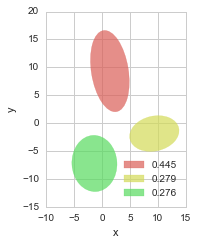

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.982  0.010      0.689  1.306311e-08      0.034       0.180

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.381  1.268646e-08      0.034       0.177

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.436   1.379   9.408  3.460  7.143  -0.285
2  0.284  -1.382  -7.083  4.084  5.117  -0.023
3  0.281   9.196  -1.881  4.468  3.288   0.180

GMM Plot Result
0.435555129538 [[ 1.37857075  9.40756574]] [ 3.27769375  7.22893778] -170.082324851
0.283617167574 [[-1.38180935 -7.08330712]] [ 4.08115286  5.11958428] -177.060273181
0.280827702889 [[ 9.19646981 -1.88137175]] [ 3.17843069  4.54718695] -74.9731523038


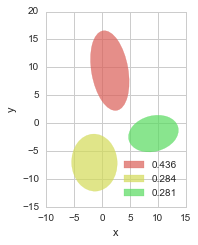

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.982  0.011      0.309  1.370472e-08      0.035       0.184

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.012      0.367  1.287598e-08      0.034       0.178

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.432   1.339   9.584  3.462  7.130  -0.275
2  0.286  -1.293  -7.041  4.103  5.177  -0.025
3  0.282   9.283  -1.842  4.398  3.253   0.152

GMM Plot Result
0.432419297582 [[ 1.33920912  9.58420518]] [ 3.29126742  7.21044833] -170.369188628
0.285665761115 [[-1.29326884 -7.04093369]] [ 4.09932594  5.17997958] -176.953146236
0.281914941303 [[ 9.28288369 -1.84170112]] [ 3.17364363  4.45585949] -76.7972370262


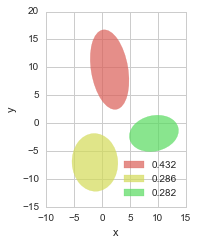

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.982  0.011      0.231  1.321260e-08      0.035       0.180

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.337  1.269797e-08      0.034       0.177

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.437   1.387   9.443  3.493  7.242  -0.298
2  0.286  -1.290  -7.045  4.031  5.129  -0.019
3  0.277   9.399  -1.807  4.384  3.221   0.167

GMM Plot Result
0.437094464375 [[ 1.38745503  9.4432912 ]] [ 3.29144144  7.33584022] -169.736928687
0.285876096047 [[-1.28992894 -7.04462363]] [ 4.02894413  5.13089829] -177.792849935
0.277029439578 [[ 9.39896407 -1.8073886 ]] [ 3.1278225   4.45023816] -75.9635927341


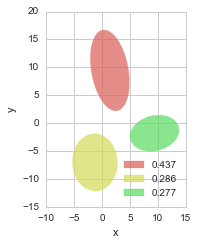

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.982  0.011      0.399  1.303890e-08      0.034       0.179

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.400  1.274669e-08      0.034       0.177

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.443   1.308   9.275  3.457  7.166  -0.248
2  0.286   9.267  -1.850  4.423  3.303   0.165
3  0.271  -1.425  -7.404  4.023  4.932  -0.028

GMM Plot Result
0.443389414646 [[ 1.30781086  9.27500836]] [ 3.31831814  7.23132387] -171.327397138
0.285972222222 [[ 9.2671489  -1.84997663]] [ 3.20669248  4.49312251] -75.4211685531
0.270638363132 [[-1.4251308  -7.40438299]] [ 4.01863218  4.93565446] -176.151332961


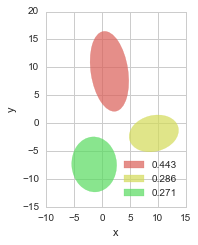

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.647  1.263219e-08      0.034       0.177

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.392  1.275321e-08      0.034       0.177

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.433   1.329   9.537  3.466  7.136  -0.272
2  0.287   9.250  -1.841  4.396  3.258   0.162
3  0.280  -1.327  -7.186  4.058  5.053  -0.012

GMM Plot Result
0.433262930616 [[ 1.32911966  9.53672198]] [ 3.29898204  7.21442326] -170.459083499
0.286970662342 [[ 9.25013374 -1.84071542]] [ 3.16798188  4.46068226] -76.0049499643
0.279766407041 [[-1.32685429 -7.1859913 ]] [ 4.05724753  5.05410657] -178.439107037


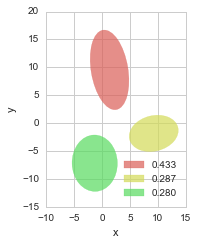

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.320  1.277226e-08      0.032       0.178

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.010      0.399  1.272887e-08      0.034       0.177

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.432   1.363   9.589  3.456  7.040  -0.257
2  0.284   9.220  -1.866  4.467  3.237   0.141
3  0.284  -1.242  -7.192  4.100  5.045  -0.011

GMM Plot Result
0.43221591356 [[ 1.36291211  9.5891143 ]] [ 3.3071637   7.11151793] -170.817007659
0.284101310453 [[ 9.22048747 -1.86579583]] [ 3.1712245   4.51434039] -78.3293587045
0.283682775986 [[-1.24174097 -7.19232093]] [ 4.09925287  5.04569398] -178.490263323


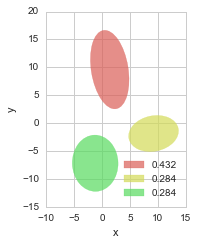

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.982  0.011      0.352  1.354040e-08      0.035       0.183

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.362  1.271380e-08      0.034       0.177

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.441   1.339   9.500  3.488  7.225  -0.271
2  0.280  -1.253  -7.064  4.093  5.066  -0.005
3  0.279   9.411  -1.842  4.409  3.231   0.141

GMM Plot Result
0.441059839644 [[ 1.33873671  9.50035786]] [ 3.32166131  7.30268938] -170.570640835
0.280336655367 [[-1.25268552 -7.06364292]] [ 4.09316777  5.06626759] -179.354017234
0.278603504989 [[ 9.4105234  -1.84189113]] [ 3.1643638   4.45733439] -77.9978708266


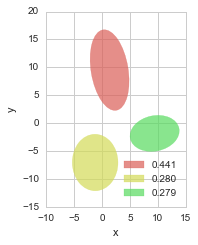

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.010      0.439  1.264139e-08      0.034       0.177

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.348  1.273761e-08      0.034       0.177

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.431   1.306   9.553  3.448  6.997  -0.250
2  0.286  -1.196  -7.147  4.157  5.051   0.005
3  0.283   9.381  -1.761  4.420  3.256   0.130

GMM Plot Result
0.430977580614 [[ 1.306027    9.55259877]] [ 3.30571242  7.06536893] -170.972073481
0.285608637991 [[-1.19597634 -7.14733796]] [ 4.15649895  5.05102305] 179.316392413
0.283413781395 [[ 9.3811582  -1.76087463]] [ 3.1970948   4.46284991] -78.6131293595


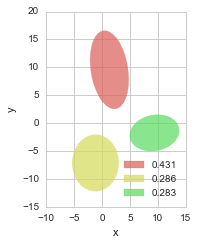

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.532  1.232116e-08      0.033       0.174

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.350  1.272063e-08      0.034       0.177

weight  mean_x  mean_y  sig_x  sig_y    corr
1  0.438   1.356   9.506  3.478  7.064  -0.251
2  0.281   9.286  -1.902  4.437  3.223   0.149
3  0.281  -1.324  -7.200  4.048  5.053  -0.005

GMM Plot Result
0.437854845122 [[ 1.35576062  9.50569229]] [ 3.33362635  7.13330795] -170.949014134
0.281445963108 [[ 9.28622674 -1.90208336]] [ 3.1504858   4.48897139] -77.7110539108
0.280699191771 [[-1.32369949 -7.19981234]] [ 4.04797685  5.05321273] -179.381806345


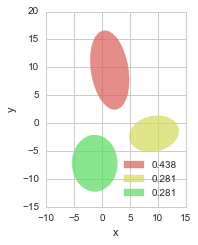

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.377  1.256661e-08      0.034       0.176

R_square    K_S Chi_square           MSE RMSE / Max RMSE / Mean
0    0.983  0.011      0.377  1.271069e-08      0.034       0.177


CPU times: user 3.05 s, sys: 196 ms, total: 3.24 s
Wall time: 26.9 s


In [69]:
%%time
results = Parallel(n_jobs=-1)(delayed(resampled_fitting)(df) for i in range(10))                        
for result in results:
    display(pretty_print_gmm(result['gmm']))
    fig,ax = plt.subplots(figsize=(3.5,3.5))
    plot_gmm_ellipses(result['gmm'],ax=ax)
    plt.show()
    display(gof_df(result['gmm_pdf_result'], result['kde_result']))
    display(gof_df(result['gmm_pdf_result'], kde_result))
    print ''

## 6.2 Cross-validation, to select the number of Gaussian

In [70]:
def fit_per_fold(df, train_index, test_index):
    sub_df, sub_df_test = df.iloc[train_index], df.iloc[test_index]

    # 1. Train
    result = fit_gmm(sub_df, fit_method = FIT_METHOD, 
                     config=config, number_of_gaussian=number_of_gaussian)
    gmm_pdf_result_train = result['gmm_pdf_result']
    kde_result_train = result['kde_result']

    # 2. Validate
    # GMM from Train - KDE from Test
    sample = array(zip(sub_df_test.x, sub_df_test.y))
    kde_test = neighbors.KernelDensity(bandwidth=bandwidth).fit(sample) 
    kde_result_test = exp(kde_test.score_samples(points))

    gof_train = goodness_of_fit_summary(gmm_pdf_result_train, 
                                        kde_result_train,)
    gof_test =  goodness_of_fit_summary(gmm_pdf_result_train, 
                                        kde_result_test,)
    return gof_train, gof_test

In [71]:
%%time
from sklearn.cross_validation import train_test_split, KFold

## 5-fold cross validation
gaussian_number_range = arange(1,7)
CV_result_train_all,CV_result_test_all =[],[]
number_of_fold = 4
print 'Number of train/test dataset', len(df)*(number_of_fold-1)/number_of_fold, len(df)/number_of_fold

for number_of_gaussian in gaussian_number_range:
    print '  '
    print 'Number of gaussian', number_of_gaussian
    
    kf = KFold(len(df), n_folds=number_of_fold, shuffle=True) 

    CV_result = Parallel(n_jobs=-1)(delayed(fit_per_fold)(df, train_index, test_index) for train_index, test_index in kf)                        
    CV_result_train, CV_result_test = zip(*CV_result)
    CV_result_train, CV_result_test = list(CV_result_train), list(CV_result_test)
        
    CV_result_train_all.append(CV_result_train)
    CV_result_test_all.append(CV_result_test)
    
    print 'Train'
    pretty_pd_display(CV_result_train)
    print 'Test'
    pretty_pd_display(CV_result_test)

Number of train/test dataset 57354.75 19118.25
  
Number of gaussian 1
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.414696  0.074407  2.230789e-07    0.142274     0.742227  0.699437
1    0.411796  0.074066  2.210218e-07    0.140551     0.738865  0.702210
2    0.413529  0.073688  2.224594e-07    0.142023     0.740673  0.700918
3    0.414940  0.075008  2.232985e-07    0.141795     0.742755  0.698110

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.412786  0.076229  2.202701e-07    0.139068     0.737249  0.703166
1    0.423700  0.075240  2.282624e-07    0.145802     0.750298  0.692381
2    0.419137  0.074722  2.254252e-07    0.141468     0.747407  0.694416
3    0.408103  0.070978  2.197154e-07    0.140604     0.735836  0.706942

  
Number of gaussian 2
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.514460  0.028690  4.735779e-08    0.064985     0.341742  0.936112
1    0.733573  0.027950  4.609490e-08    0.064448     0.337517  0.937830
2    0.627407  0.028639  4.612398e-08    0.064782     0.337489  0.938101
3    1.122728  0.029295  4.874124e-08    0.066540     0.346928  0.934138

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    2.046079  0.028293  4.735928e-08    0.066646     0.342575  0.936425
1    0.862858  0.028454  5.144495e-08    0.068267     0.355896  0.930918
2    1.601667  0.032238  5.117097e-08    0.066964     0.355372  0.930227
3    0.099740  0.028100  4.323239e-08    0.061922     0.326654  0.942250

  
Number of gaussian 3
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.388189  0.010500  1.211221e-08    0.032706     0.173006  0.983681
1    0.432895  0.010675  1.260806e-08    0.033721     0.176468  0.983014
2    0.325529  0.010282  1.279481e-08    0.033884     0.177714  0.982749
3    0.483842  0.010638  1.309380e-08    0.034706     0.179719  0.982349

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.689252  0.010790  1.617151e-08    0.039534     0.199564  0.978225
1    0.383474  0.009672  1.420511e-08    0.035286     0.187177  0.980859
2    0.985555  0.013352  1.388598e-08    0.035370     0.185239  0.981336
3    0.345520  0.014150  1.270172e-08    0.032500     0.177341  0.982913

  
Number of gaussian 4
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0   15.239882  0.009564  5.874647e-09    0.023064     0.120422  0.992074
1   11.691867  0.008511  5.598587e-09    0.022352     0.117666  0.992450
2    8.180441  0.009629  5.317589e-09    0.021870     0.114487  0.992827
3    3.251785  0.009604  6.501632e-09    0.024157     0.126720  0.991259

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    6.461937  0.008291  6.072618e-09    0.022941     0.122489  0.991848
1   17.202554  0.013300  6.857155e-09    0.024906     0.129808  0.990782
2   34.773460  0.008163  8.336889e-09    0.026702     0.143837  0.988811
3   33.387122  0.006653  7.026098e-09    0.025417     0.131647  0.990473

  
Number of gaussian 5
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.014267  0.004695  4.508883e-09    0.020029     0.105544  0.993935
1    0.169284  0.009875  4.259336e-09    0.019715     0.102581  0.994249
2    0.165744  0.010076  4.023640e-09    0.019040     0.099681  0.994571
3    0.013047  0.004997  4.854313e-09    0.020926     0.109403  0.993465

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.019650  0.008473  6.549138e-09    0.024669     0.127045  0.991134
1    0.201151  0.013669  5.667654e-09    0.022003     0.118189  0.992413
2    0.230105  0.015597  6.598596e-09    0.024219     0.127608  0.991150
3    0.016079  0.014828  5.946739e-09    0.023207     0.121425  0.991976

  
Number of gaussian 6
Train


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.013417  0.003544  3.960830e-09    0.018938     0.098949  0.994652
1    0.015005  0.005061  3.989853e-09    0.019105     0.099222  0.994643
2    0.010592  0.003903  3.537828e-09    0.017802     0.093435  0.995224
3    0.012743  0.003854  3.653331e-09    0.018036     0.094976  0.995075

Test


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
0    0.017178  0.016349  5.277200e-09    0.021592     0.113947  0.992940
1    0.015424  0.008000  5.323963e-09    0.021505     0.114760  0.992754
2    0.023812  0.004582  5.960848e-09    0.023262     0.121420  0.992013
3    0.016229  0.009548  6.429467e-09    0.024377     0.125990  0.991359

CPU times: user 1.52 s, sys: 415 ms, total: 1.93 s
Wall time: 1min 37s


In [72]:
train_scores_mean, train_scores_std = generate_mean_std_gof(CV_result_train_all)
print 'Train gof mean, std'
display(train_scores_mean)

test_scores_mean, test_scores_std = generate_mean_std_gof(CV_result_test_all)
print 'Test gof mean, std'
display(test_scores_mean)

Train gof mean, std


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
1    0.413740  0.074292  2.224647e-07    0.141661     0.741130  0.700169
2    0.749542  0.028644  4.707948e-08    0.065189     0.340919  0.936545
3    0.407614  0.010524  1.265222e-08    0.033754     0.176727  0.982948
4    9.590994  0.009327  5.823114e-09    0.022861     0.119824  0.992153
5    0.090585  0.007411  4.411543e-09    0.019927     0.104302  0.994055
6    0.012939  0.004090  3.785460e-09    0.018470     0.096646  0.994899

Test gof mean, std


Chi_square       K_S           MSE  RMSE / Max  RMSE / Mean  R_square
1    0.415931  0.074292  2.234183e-07    0.141735     0.742697  0.699226
2    1.152586  0.029271  4.830190e-08    0.065950     0.345124  0.934955
3    0.600950  0.011991  1.424108e-08    0.035672     0.187330  0.980833
4   22.956268  0.009102  7.073190e-09    0.024992     0.131945  0.990478
5    0.116746  0.013142  6.190532e-09    0.023524     0.123567  0.991668
6    0.018161  0.009620  5.747869e-09    0.022684     0.119029  0.992267

R_square


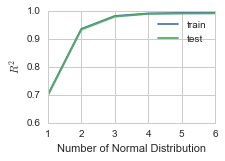

K_S


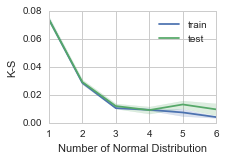

Chi_square


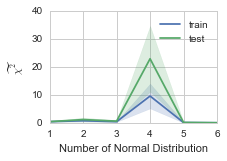

In [73]:
prop_cycle=mpl.rcParams['axes.color_cycle']
gaussian_number_range = train_scores_mean.index
for column, column_name in zip(['R_square','K_S','Chi_square'],["$\ R^2$", "K-S", "$\widetilde{\chi^2} $"]):
    plot(gaussian_number_range, train_scores_mean[column],
             '-', label = 'train', color=prop_cycle[0])
    plt.fill_between(gaussian_number_range, 
                     train_scores_mean[column] - train_scores_std[column],
                     train_scores_mean[column] + train_scores_std[column], 
                     alpha=0.2, color=prop_cycle[0])
    
    plot(gaussian_number_range, test_scores_mean[column],
             '-', label = 'test',color=prop_cycle[1])
    plt.fill_between(gaussian_number_range, 
                 test_scores_mean[column] - test_scores_std[column],
                 test_scores_mean[column] + test_scores_std[column], 
                 alpha=0.2,color=prop_cycle[1])
    plt.xticks(gaussian_number_range)
    print column
    plt.locator_params(axis='y', nbins=5)
    plt_configure(xlabel='Number of Normal Distribution', ylabel=column_name, 
                  figsize=(3,2), legend={'loc':'best'})
    plt.show()

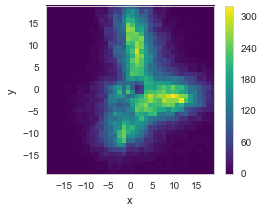

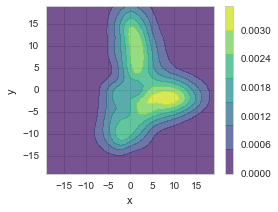

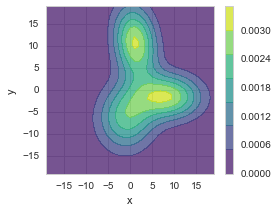

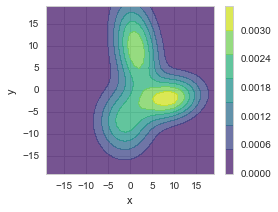

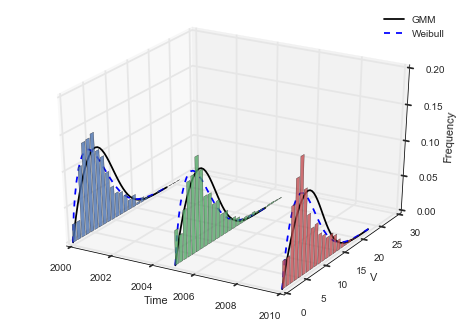

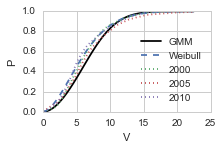

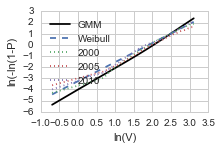

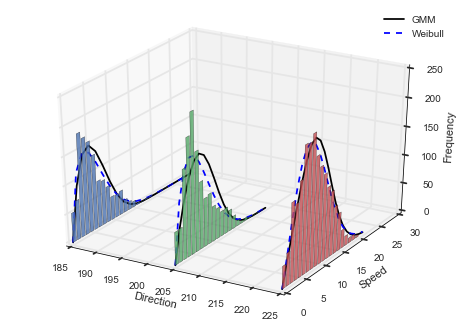

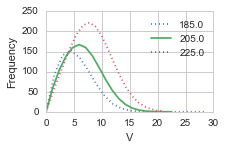

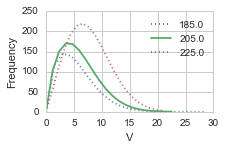

In [74]:
for fig in [fig_hist, fig_kde, fig_em, fig_gmm]:
    display(fig)
for fig in [fig_time_variability_3d, fig_time_variability_cdf, fig_time_variability_weibull, 
            fig_adjecent_variability_3d, fig_adjecent_variability_cdf, fig_adjecent_variability_weibull,]:
    display(fig)

In [75]:
import time
save_notebook()
time.sleep(3)
location_name = get_location_name(ipath)
current_file = 'GMM.ipynb'
output_file = './output_HTML/'+location_name+'.html' 
output_HTML(current_file, output_file)